# Transformer For TimeSeries Forecasting Multivariate series (co2)

https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_10_5_keras_transformers.ipynb

https://keras.io/examples/timeseries/

# Libraries

In [1]:
#!pip install optuna

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import optuna
import matplotlib.pyplot as plt
import os
from keras.models import load_model
#%tensorflow_version 2.x

# Data

In [3]:
df = pd.read_csv('DataSets /WORLD-OWID-Features')
df.set_index('year', inplace=True)
df.tail(3)


cement_co2        co2   coal_co2  flaring_co2   gas_co2  \
year                                                            
2019    1617.507  37082.559  14725.978      439.254  7647.528   
2020    1637.537  35264.086  14174.564      407.584  7556.290   
2021    1672.592  37123.852  14979.598      416.526  7921.830   

      land_use_change_co2    oil_co2  other_industry_co2  
year                                                      
2019             4557.283  12345.653             306.639  
2020             4057.758  11191.809             296.302  
2021             3939.044  11837.159             296.146

As we can see tha value of 2020 is an outlier compared to the other years because of corona... We will change this value with the mean of 2019 and 2021 combined. This way our future predictions/foreastings will be more accurate. 

In [4]:
mean_co2 = df.loc[[2019, 2021], 'co2'].mean()
df.loc[2020, 'co2'] = mean_co2

df.tail(5)

cement_co2         co2   coal_co2  flaring_co2   gas_co2  \
year                                                             
2017    1507.923  36096.7380  14506.974      391.992  7144.928   
2018    1569.218  36826.5080  14746.831      412.116  7529.847   
2019    1617.507  37082.5590  14725.978      439.254  7647.528   
2020    1637.537  37103.2055  14174.564      407.584  7556.290   
2021    1672.592  37123.8520  14979.598      416.526  7921.830   

      land_use_change_co2    oil_co2  other_industry_co2  
year                                                      
2017             4331.947  12242.628             302.294  
2018             4181.356  12266.017             302.479  
2019             4557.283  12345.653             306.639  
2020             4057.758  11191.809             296.302  
2021             3939.044  11837.159             296.146

# Defining our train, test & val set

In [5]:
train_set = df[(df.index > 1879) & (df.index <= 2000)]
test_set = df[(df.index > 2000) & (df.index <= 2011)]
validate_set = df[df.index > 2011]

print("Train set:")
print(train_set.index.min(), "to", train_set.index.max())

print("Test set:")
print(test_set.index.min(), "to", test_set.index.max())

print("Validation set:")
print(validate_set.index.min(), "to", validate_set.index.max())

Train set:
1880 to 2000
Test set:
2001 to 2011
Validation set:
2012 to 2021


In [6]:
train_data = [train_set[column].tolist() for column in train_set.columns]
test_data = [test_set[column].tolist() for column in test_set.columns]
val_data = [validate_set[column].tolist() for column in validate_set.columns]

# defining our Window/LookBack length





In [7]:
import numpy as np

def to_sequences(seq_size, obs_list):
    x = []
    y = []

    for i in range(len(obs_list[0]) - seq_size):
        window = [obs[i:i + seq_size] for obs in obs_list]
        after_window = [obs[i + seq_size] for obs in obs_list]
        x.append(window)
        y.append(after_window)

    return np.array(x), np.array(y)

SEQUENCE_SIZE = 5

train_data = [train_set[column].tolist() for column in train_set.columns]
test_data = [test_set[column].tolist() for column in test_set.columns]
val_data = [validate_set[column].tolist() for column in validate_set.columns]

x_train, y_train = to_sequences(SEQUENCE_SIZE, train_data)
x_test, y_test = to_sequences(SEQUENCE_SIZE, test_data)
x_val, y_val = to_sequences(SEQUENCE_SIZE, val_data)

print("Shape of training set: {}".format(x_train.shape))
print("Shape of test set: {}".format(x_test.shape))
print("Shape of val set: {}".format(x_val.shape))


Shape of training set: (116, 8, 5)
Shape of test set: (6, 8, 5)
Shape of val set: (5, 8, 5)


# Scaling Data

In [8]:
'''train_data = np.log(train_data)
test_data = np.log(test_data)
val_data = np.log(val_data)'''

'train_data = np.log(train_data)\ntest_data = np.log(test_data)\nval_data = np.log(val_data)'

In [9]:
'''from sklearn.preprocessing import StandardScaler

# Maak een scaler voor de kenmerken (X)
feature_scaler = StandardScaler()
X_train_scaled = feature_scaler.fit_transform(x_train)
X_test_scaled = feature_scaler.transform(x_test)
X_val_scaled = feature_scaler.transform(x_val)

# Maak een scaler voor de doelvariabelen (y)
target_scaler = StandardScaler()
y_train_scaled = target_scaler.fit_transform(y_train)
y_test_scaled = target_scaler.transform(y_test)
y_val_scaled = target_scaler.transform(y_val)'''


'from sklearn.preprocessing import StandardScaler\n\n# Maak een scaler voor de kenmerken (X)\nfeature_scaler = StandardScaler()\nX_train_scaled = feature_scaler.fit_transform(x_train)\nX_test_scaled = feature_scaler.transform(x_test)\nX_val_scaled = feature_scaler.transform(x_val)\n\n# Maak een scaler voor de doelvariabelen (y)\ntarget_scaler = StandardScaler()\ny_train_scaled = target_scaler.fit_transform(y_train)\ny_test_scaled = target_scaler.transform(y_test)\ny_val_scaled = target_scaler.transform(y_val)'

# Metrics Helper Function

In [8]:
def print_metrics(pred, y_test, model_name):
    mae_ = mean_absolute_error(pred, y_test)
    rmse_ = np.sqrt(mean_squared_error(pred, y_test))
    mape_ = mean_absolute_percentage_error(pred, y_test)
    r2_score_ = r2_score(pred, y_test)

    dict_ = {
        'MAE': mae_,
        'RMSE': rmse_,
        'MAPE': mape_,
        'R2': r2_score_
    }

    metrics = pd.DataFrame(dict_, index=[model_name])

    return metrics.round(decimals=2)

# Building the Transformer Model

In [11]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)    #!! 
    return x + res

In [12]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="linear")(x)
        x = layers.Dropout(mlp_dropout)(x)
    x = layers.Dense(16)(x)
    outputs = layers.Dense(8)(x)
    return keras.Model(inputs, outputs)

# Using Optuna for Optimal Paramater search



In [13]:
def objective(trial):

  input_shape = x_train.shape[1:]

  head_size = trial.suggest_int("head_size", 64, 256)
  num_heads = trial.suggest_int("num_heads", 4, 8)
  ff_dim = trial.suggest_int("ff_dim", 8, 24)
  num_transformer_blocks = trial.suggest_int("num_transformer_blocks", 4, 8)
  mlp_units = [trial.suggest_int("mlp_units", 64, 128)]
  mlp_dropout = trial.suggest_float("mlp_dropout", 0.1, 0.35)
  dropout = trial.suggest_float("dropout", 0.1, 0.35)
  learning_rate = trial.suggest_float("learning_rate", 1e-6, 1e-3, log=True)
  n_epochs = trial.suggest_int("n_epochs", 32, 128)
  #batch_size = trial.suggest_int("batch_size", 16, 128, step=16)

  model = build_model(
      input_shape,
      head_size=head_size,
      num_heads=num_heads,
      ff_dim=ff_dim,
      num_transformer_blocks=num_transformer_blocks,
      mlp_units=mlp_units,
      mlp_dropout=mlp_dropout,
      dropout=dropout,
  )

  model.compile(
      loss="mean_absolute_error",
      optimizer=keras.optimizers.legacy.Adam(learning_rate=learning_rate)
  )
  model.summary()

  callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

  model.fit(
      x_train,
      y_train,
      validation_split=0.15,
      epochs=n_epochs,
      batch_size=128,
      callbacks=callbacks,
  )

  loss = model.evaluate(x_test, y_test, verbose=1)
  return loss

In [14]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=150)

[I 2023-08-14 04:55:24,868] A new study created in memory with name: no-name-fb91986d-8165-4448-98d6-89f39a63cb8b


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization (Layer  (None, 8, 5)                 10        ['input_1[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 multi_head_attention (Mult  (None, 8, 5)                 15277     ['layer_normalization[0][0]', 
 iHeadAttention)                                                     'layer_normalization[0][0]'] 
                                                                                              

[I 2023-08-14 04:55:32,491] Trial 0 finished with value: 12441.6513671875 and parameters: {'head_size': 166, 'num_heads': 4, 'ff_dim': 19, 'num_transformer_blocks': 7, 'mlp_units': 107, 'mlp_dropout': 0.18521665713413, 'dropout': 0.2326862356485837, 'learning_rate': 1.19298686300473e-06, 'n_epochs': 72}. Best is trial 0 with value: 12441.6513671875.


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_14 (La  (None, 8, 5)                 10        ['input_2[0][0]']             
 yerNormalization)                                                                                
                                                                                                  
 multi_head_attention_7 (Mu  (None, 8, 5)                 29445     ['layer_normalization_14[0][0]
 ltiHeadAttention)                                                  ',                            
                                                                     'layer_normalization_14

[I 2023-08-14 04:55:36,251] Trial 1 finished with value: 12566.3720703125 and parameters: {'head_size': 256, 'num_heads': 5, 'ff_dim': 10, 'num_transformer_blocks': 4, 'mlp_units': 72, 'mlp_dropout': 0.21014109828108885, 'dropout': 0.31630462005319987, 'learning_rate': 2.9241358170666334e-06, 'n_epochs': 44}. Best is trial 0 with value: 12441.6513671875.


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_22 (La  (None, 8, 5)                 10        ['input_3[0][0]']             
 yerNormalization)                                                                                
                                                                                                  
 multi_head_attention_11 (M  (None, 8, 5)                 18980     ['layer_normalization_22[0][0]
 ultiHeadAttention)                                                 ',                            
                                                                     'layer_normalization_22

[I 2023-08-14 04:55:45,405] Trial 2 finished with value: 10422.0439453125 and parameters: {'head_size': 165, 'num_heads': 5, 'ff_dim': 23, 'num_transformer_blocks': 6, 'mlp_units': 88, 'mlp_dropout': 0.2592747334047554, 'dropout': 0.23165342755043025, 'learning_rate': 3.5395256152324106e-06, 'n_epochs': 109}. Best is trial 2 with value: 10422.0439453125.


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_34 (La  (None, 8, 5)                 10        ['input_4[0][0]']             
 yerNormalization)                                                                                
                                                                                                  
 multi_head_attention_17 (M  (None, 8, 5)                 20889     ['layer_normalization_34[0][0]
 ultiHeadAttention)                                                 ',                            
                                                                     'layer_normalization_34

[I 2023-08-14 04:55:57,733] Trial 3 finished with value: 12917.6884765625 and parameters: {'head_size': 227, 'num_heads': 4, 'ff_dim': 9, 'num_transformer_blocks': 8, 'mlp_units': 81, 'mlp_dropout': 0.24412623929852514, 'dropout': 0.26660865257139776, 'learning_rate': 1.3456211580894826e-05, 'n_epochs': 126}. Best is trial 2 with value: 10422.0439453125.


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_50 (La  (None, 8, 5)                 10        ['input_5[0][0]']             
 yerNormalization)                                                                                
                                                                                                  
 multi_head_attention_25 (M  (None, 8, 5)                 24316     ['layer_normalization_50[0][0]
 ultiHeadAttention)                                                 ',                            
                                                                     'layer_normalization_50

[I 2023-08-14 04:56:06,365] Trial 4 finished with value: 9516.9404296875 and parameters: {'head_size': 151, 'num_heads': 7, 'ff_dim': 18, 'num_transformer_blocks': 6, 'mlp_units': 104, 'mlp_dropout': 0.23061960546982957, 'dropout': 0.28650991167230483, 'learning_rate': 9.621532122908162e-06, 'n_epochs': 95}. Best is trial 4 with value: 9516.9404296875.


Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_62 (La  (None, 8, 5)                 10        ['input_6[0][0]']             
 yerNormalization)                                                                                
                                                                                                  
 multi_head_attention_31 (M  (None, 8, 5)                 15737     ['layer_normalization_62[0][0]
 ultiHeadAttention)                                                 ',                            
                                                                     'layer_normalization_62

[I 2023-08-14 04:56:18,615] Trial 5 finished with value: 12420.7646484375 and parameters: {'head_size': 114, 'num_heads': 6, 'ff_dim': 12, 'num_transformer_blocks': 8, 'mlp_units': 96, 'mlp_dropout': 0.12636644927851706, 'dropout': 0.19815825984956442, 'learning_rate': 1.0320805027001957e-05, 'n_epochs': 128}. Best is trial 4 with value: 9516.9404296875.


Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_78 (La  (None, 8, 5)                 10        ['input_7[0][0]']             
 yerNormalization)                                                                                
                                                                                                  
 multi_head_attention_39 (M  (None, 8, 5)                 26363     ['layer_normalization_78[0][0]
 ultiHeadAttention)                                                 ',                            
                                                                     'layer_normalization_78

[I 2023-08-14 04:56:29,093] Trial 6 finished with value: 3079.1923828125 and parameters: {'head_size': 191, 'num_heads': 6, 'ff_dim': 14, 'num_transformer_blocks': 6, 'mlp_units': 115, 'mlp_dropout': 0.23621110961319586, 'dropout': 0.17161834763912254, 'learning_rate': 0.000420797273853477, 'n_epochs': 115}. Best is trial 6 with value: 3079.1923828125.


Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_90 (La  (None, 8, 5)                 10        ['input_8[0][0]']             
 yerNormalization)                                                                                
                                                                                                  
 multi_head_attention_45 (M  (None, 8, 5)                 27053     ['layer_normalization_90[0][0]
 ultiHeadAttention)                                                 ',                            
                                                                     'layer_normalization_90

[I 2023-08-14 04:56:33,188] Trial 7 finished with value: 7106.67626953125 and parameters: {'head_size': 196, 'num_heads': 6, 'ff_dim': 10, 'num_transformer_blocks': 4, 'mlp_units': 97, 'mlp_dropout': 0.3124258585524677, 'dropout': 0.18157602064166845, 'learning_rate': 0.0001895527620823569, 'n_epochs': 52}. Best is trial 6 with value: 3079.1923828125.


Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_98 (La  (None, 8, 5)                 10        ['input_9[0][0]']             
 yerNormalization)                                                                                
                                                                                                  
 multi_head_attention_49 (M  (None, 8, 5)                 39611     ['layer_normalization_98[0][0]
 ultiHeadAttention)                                                 ',                            
                                                                     'layer_normalization_98

[I 2023-08-14 04:56:40,865] Trial 8 finished with value: 3386.190185546875 and parameters: {'head_size': 246, 'num_heads': 7, 'ff_dim': 21, 'num_transformer_blocks': 7, 'mlp_units': 68, 'mlp_dropout': 0.20873354587595938, 'dropout': 0.1508442415311275, 'learning_rate': 0.0005088422450222025, 'n_epochs': 54}. Best is trial 6 with value: 3079.1923828125.


Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_112 (L  (None, 8, 5)                 10        ['input_10[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_56 (M  (None, 8, 5)                 20590     ['layer_normalization_112[0][0
 ultiHeadAttention)                                                 ]',                           
                                                                     'layer_normalization_11

[I 2023-08-14 04:56:49,779] Trial 9 finished with value: 8244.50390625 and parameters: {'head_size': 179, 'num_heads': 5, 'ff_dim': 13, 'num_transformer_blocks': 5, 'mlp_units': 122, 'mlp_dropout': 0.2511473343587428, 'dropout': 0.25320610848849623, 'learning_rate': 3.986954870831712e-05, 'n_epochs': 111}. Best is trial 6 with value: 3079.1923828125.


Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_122 (L  (None, 8, 5)                 10        ['input_11[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_61 (M  (None, 8, 5)                 17669     ['layer_normalization_122[0][0
 ultiHeadAttention)                                                 ]',                           
                                                                     'layer_normalization_1

[I 2023-08-14 04:56:55,337] Trial 10 finished with value: 2064.262451171875 and parameters: {'head_size': 96, 'num_heads': 8, 'ff_dim': 15, 'num_transformer_blocks': 5, 'mlp_units': 128, 'mlp_dropout': 0.3347318117042113, 'dropout': 0.11411285022795216, 'learning_rate': 0.0007397966508668667, 'n_epochs': 86}. Best is trial 10 with value: 2064.262451171875.


Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_12 (InputLayer)       [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_132 (L  (None, 8, 5)                 10        ['input_12[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_66 (M  (None, 8, 5)                 12701     ['layer_normalization_132[0][0
 ultiHeadAttention)                                                 ]',                           
                                                                     'layer_normalization_1

[I 2023-08-14 04:56:59,636] Trial 11 finished with value: 1956.4801025390625 and parameters: {'head_size': 69, 'num_heads': 8, 'ff_dim': 15, 'num_transformer_blocks': 5, 'mlp_units': 127, 'mlp_dropout': 0.3421997490902338, 'dropout': 0.1041717845797991, 'learning_rate': 0.0008368736267677749, 'n_epochs': 79}. Best is trial 11 with value: 1956.4801025390625.


Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_13 (InputLayer)       [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_142 (L  (None, 8, 5)                 10        ['input_13[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_71 (M  (None, 8, 5)                 11781     ['layer_normalization_142[0][0
 ultiHeadAttention)                                                 ]',                           
                                                                     'layer_normalization_1

[I 2023-08-14 04:57:03,622] Trial 12 finished with value: 1480.3642578125 and parameters: {'head_size': 64, 'num_heads': 8, 'ff_dim': 17, 'num_transformer_blocks': 5, 'mlp_units': 127, 'mlp_dropout': 0.3416107806292955, 'dropout': 0.1100916571505177, 'learning_rate': 0.0009907589884601302, 'n_epochs': 80}. Best is trial 12 with value: 1480.3642578125.


Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_14 (InputLayer)       [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_152 (L  (None, 8, 5)                 10        ['input_14[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_76 (M  (None, 8, 5)                 11781     ['layer_normalization_152[0][0
 ultiHeadAttention)                                                 ]',                           
                                                                     'layer_normalization_1

[I 2023-08-14 04:57:09,030] Trial 13 finished with value: 4039.681640625 and parameters: {'head_size': 64, 'num_heads': 8, 'ff_dim': 17, 'num_transformer_blocks': 5, 'mlp_units': 117, 'mlp_dropout': 0.34982513829625556, 'dropout': 0.1086812270139244, 'learning_rate': 0.00014207368595739713, 'n_epochs': 72}. Best is trial 12 with value: 1480.3642578125.


Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_15 (InputLayer)       [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_162 (L  (None, 8, 5)                 10        ['input_15[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_81 (M  (None, 8, 5)                 12333     ['layer_normalization_162[0][0
 ultiHeadAttention)                                                 ]',                           
                                                                     'layer_normalization_1

[I 2023-08-14 04:57:12,509] Trial 14 finished with value: 2460.331298828125 and parameters: {'head_size': 67, 'num_heads': 8, 'ff_dim': 16, 'num_transformer_blocks': 5, 'mlp_units': 127, 'mlp_dropout': 0.30604657929053397, 'dropout': 0.1305762716356286, 'learning_rate': 0.0009420865928944417, 'n_epochs': 88}. Best is trial 12 with value: 1480.3642578125.


Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_16 (InputLayer)       [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_172 (L  (None, 8, 5)                 10        ['input_16[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_86 (M  (None, 8, 5)                 17393     ['layer_normalization_172[0][0
 ultiHeadAttention)                                                 ]',                           
                                                                     'layer_normalization_1

[I 2023-08-14 04:57:17,172] Trial 15 finished with value: 5553.24853515625 and parameters: {'head_size': 108, 'num_heads': 7, 'ff_dim': 20, 'num_transformer_blocks': 4, 'mlp_units': 112, 'mlp_dropout': 0.3033626677042148, 'dropout': 0.10132995021344378, 'learning_rate': 0.0001863040817766105, 'n_epochs': 67}. Best is trial 12 with value: 1480.3642578125.


Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_17 (InputLayer)       [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_180 (L  (None, 8, 5)                 10        ['input_17[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_90 (M  (None, 8, 5)                 25949     ['layer_normalization_180[0][0
 ultiHeadAttention)                                                 ]',                           
                                                                     'layer_normalization_1

[I 2023-08-14 04:57:20,976] Trial 16 finished with value: 8441.5751953125 and parameters: {'head_size': 141, 'num_heads': 8, 'ff_dim': 24, 'num_transformer_blocks': 5, 'mlp_units': 122, 'mlp_dropout': 0.3478171708481306, 'dropout': 0.14324907701132958, 'learning_rate': 6.898984550522814e-05, 'n_epochs': 32}. Best is trial 12 with value: 1480.3642578125.


Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_18 (InputLayer)       [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_190 (L  (None, 8, 5)                 10        ['input_18[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_95 (M  (None, 8, 5)                 14173     ['layer_normalization_190[0][0
 ultiHeadAttention)                                                 ]',                           
                                                                     'layer_normalization_1

[I 2023-08-14 04:57:29,516] Trial 17 finished with value: 2179.288330078125 and parameters: {'head_size': 88, 'num_heads': 7, 'ff_dim': 12, 'num_transformer_blocks': 7, 'mlp_units': 106, 'mlp_dropout': 0.28160903945215315, 'dropout': 0.15057321905920878, 'learning_rate': 0.00047575680773415124, 'n_epochs': 96}. Best is trial 12 with value: 1480.3642578125.


Model: "model_18"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_19 (InputLayer)       [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_204 (L  (None, 8, 5)                 10        ['input_19[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_102 (  (None, 8, 5)                 23925     ['layer_normalization_204[0][0
 MultiHeadAttention)                                                ]',                           
                                                                     'layer_normalization_2

[I 2023-08-14 04:57:34,197] Trial 18 finished with value: 1577.72119140625 and parameters: {'head_size': 130, 'num_heads': 8, 'ff_dim': 16, 'num_transformer_blocks': 4, 'mlp_units': 121, 'mlp_dropout': 0.32205947513425376, 'dropout': 0.19883817040900795, 'learning_rate': 0.0009294575458587284, 'n_epochs': 62}. Best is trial 12 with value: 1480.3642578125.


Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_20 (InputLayer)       [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_212 (L  (None, 8, 5)                 10        ['input_20[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_106 (  (None, 8, 5)                 20774     ['layer_normalization_212[0][0
 MultiHeadAttention)                                                ]',                           
                                                                     'layer_normalization_2

[I 2023-08-14 04:57:38,717] Trial 19 finished with value: 3911.313232421875 and parameters: {'head_size': 129, 'num_heads': 7, 'ff_dim': 22, 'num_transformer_blocks': 4, 'mlp_units': 118, 'mlp_dropout': 0.27701803529162716, 'dropout': 0.20226735259412332, 'learning_rate': 0.0003978553724689536, 'n_epochs': 63}. Best is trial 12 with value: 1480.3642578125.


Model: "model_20"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_21 (InputLayer)       [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_220 (L  (None, 8, 5)                 10        ['input_21[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_110 (  (None, 8, 5)                 21717     ['layer_normalization_220[0][0
 MultiHeadAttention)                                                ]',                           
                                                                     'layer_normalization_2

[I 2023-08-14 04:57:42,890] Trial 20 finished with value: 6840.93017578125 and parameters: {'head_size': 118, 'num_heads': 8, 'ff_dim': 18, 'num_transformer_blocks': 4, 'mlp_units': 86, 'mlp_dropout': 0.32098047832547094, 'dropout': 0.17488932345616065, 'learning_rate': 0.0002642413727810765, 'n_epochs': 55}. Best is trial 12 with value: 1480.3642578125.


Model: "model_21"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_22 (InputLayer)       [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_228 (L  (None, 8, 5)                 10        ['input_22[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_114 (  (None, 8, 5)                 14909     ['layer_normalization_228[0][0
 MultiHeadAttention)                                                ]',                           
                                                                     'layer_normalization_2

[I 2023-08-14 04:57:46,575] Trial 21 finished with value: 2895.059814453125 and parameters: {'head_size': 81, 'num_heads': 8, 'ff_dim': 16, 'num_transformer_blocks': 5, 'mlp_units': 128, 'mlp_dropout': 0.32820519994068104, 'dropout': 0.12678803223469795, 'learning_rate': 0.0009718456291221221, 'n_epochs': 79}. Best is trial 12 with value: 1480.3642578125.


Model: "model_22"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_23 (InputLayer)       [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_238 (L  (None, 8, 5)                 10        ['input_23[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_119 (  (None, 8, 5)                 15277     ['layer_normalization_238[0][0
 MultiHeadAttention)                                                ]',                           
                                                                     'layer_normalization_2

[I 2023-08-14 04:57:52,339] Trial 22 finished with value: 1869.2933349609375 and parameters: {'head_size': 83, 'num_heads': 8, 'ff_dim': 15, 'num_transformer_blocks': 5, 'mlp_units': 122, 'mlp_dropout': 0.2925491929020014, 'dropout': 0.1028749698507966, 'learning_rate': 0.0008481239105137811, 'n_epochs': 79}. Best is trial 12 with value: 1480.3642578125.


Model: "model_23"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_24 (InputLayer)       [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_248 (L  (None, 8, 5)                 10        ['input_24[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_124 (  (None, 8, 5)                 15461     ['layer_normalization_248[0][0
 MultiHeadAttention)                                                ]',                           
                                                                     'layer_normalization_2

[I 2023-08-14 04:57:56,433] Trial 23 finished with value: 6734.04150390625 and parameters: {'head_size': 96, 'num_heads': 7, 'ff_dim': 17, 'num_transformer_blocks': 4, 'mlp_units': 111, 'mlp_dropout': 0.29478434375318774, 'dropout': 0.1329498558619891, 'learning_rate': 0.0001066189142697361, 'n_epochs': 62}. Best is trial 12 with value: 1480.3642578125.


Model: "model_24"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_25 (InputLayer)       [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_256 (L  (None, 8, 5)                 10        ['input_25[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_128 (  (None, 8, 5)                 24293     ['layer_normalization_256[0][0
 MultiHeadAttention)                                                ]',                           
                                                                     'layer_normalization_2

[I 2023-08-14 04:58:05,334] Trial 24 finished with value: 3745.7890625 and parameters: {'head_size': 132, 'num_heads': 8, 'ff_dim': 14, 'num_transformer_blocks': 6, 'mlp_units': 118, 'mlp_dropout': 0.31891292440567653, 'dropout': 0.16381509630526372, 'learning_rate': 0.0002547730757449497, 'n_epochs': 99}. Best is trial 12 with value: 1480.3642578125.


Model: "model_25"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_26 (InputLayer)       [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_268 (L  (None, 8, 5)                 10        ['input_26[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_134 (  (None, 8, 5)                 13046     ['layer_normalization_268[0][0
 MultiHeadAttention)                                                ]',                           
                                                                     'layer_normalization_2

[I 2023-08-14 04:58:11,295] Trial 25 finished with value: 1582.4036865234375 and parameters: {'head_size': 81, 'num_heads': 7, 'ff_dim': 19, 'num_transformer_blocks': 5, 'mlp_units': 121, 'mlp_dropout': 0.2862353849726065, 'dropout': 0.12527610420866622, 'learning_rate': 0.0005390680618246141, 'n_epochs': 85}. Best is trial 12 with value: 1480.3642578125.


Model: "model_26"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_27 (InputLayer)       [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_278 (L  (None, 8, 5)                 10        ['input_27[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_139 (  (None, 8, 5)                 17232     ['layer_normalization_278[0][0
 MultiHeadAttention)                                                ]',                           
                                                                     'layer_normalization_2

[I 2023-08-14 04:58:16,744] Trial 26 finished with value: 1811.2784423828125 and parameters: {'head_size': 107, 'num_heads': 7, 'ff_dim': 20, 'num_transformer_blocks': 4, 'mlp_units': 102, 'mlp_dropout': 0.32795830696652917, 'dropout': 0.12568274262520518, 'learning_rate': 0.0003542032830884351, 'n_epochs': 89}. Best is trial 12 with value: 1480.3642578125.


Model: "model_27"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_28 (InputLayer)       [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_286 (L  (None, 8, 5)                 10        ['input_28[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_143 (  (None, 8, 5)                 10769     ['layer_normalization_286[0][0
 MultiHeadAttention)                                                ]',                           
                                                                     'layer_normalization_2

[I 2023-08-14 04:58:23,053] Trial 27 finished with value: 1611.7991943359375 and parameters: {'head_size': 78, 'num_heads': 6, 'ff_dim': 18, 'num_transformer_blocks': 6, 'mlp_units': 111, 'mlp_dropout': 0.2726832233239649, 'dropout': 0.19912963138687503, 'learning_rate': 0.0005616580985458901, 'n_epochs': 102}. Best is trial 12 with value: 1480.3642578125.


Model: "model_28"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_29 (InputLayer)       [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_298 (L  (None, 8, 5)                 10        ['input_29[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_149 (  (None, 8, 5)                 16266     ['layer_normalization_298[0][0
 MultiHeadAttention)                                                ]',                           
                                                                     'layer_normalization_2

[I 2023-08-14 04:58:28,566] Trial 28 finished with value: 3423.5 and parameters: {'head_size': 101, 'num_heads': 7, 'ff_dim': 20, 'num_transformer_blocks': 5, 'mlp_units': 123, 'mlp_dropout': 0.2958145272009285, 'dropout': 0.15988171270382368, 'learning_rate': 0.00024088022583215572, 'n_epochs': 72}. Best is trial 12 with value: 1480.3642578125.


Model: "model_29"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_30 (InputLayer)       [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_308 (L  (None, 8, 5)                 10        ['input_30[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_154 (  (None, 8, 5)                 23189     ['layer_normalization_308[0][0
 MultiHeadAttention)                                                ]',                           
                                                                     'layer_normalization_3

[I 2023-08-14 04:58:32,178] Trial 29 finished with value: 4829.15185546875 and parameters: {'head_size': 126, 'num_heads': 8, 'ff_dim': 19, 'num_transformer_blocks': 4, 'mlp_units': 110, 'mlp_dropout': 0.31577063601861205, 'dropout': 0.1428399067596921, 'learning_rate': 0.0005588372392541143, 'n_epochs': 42}. Best is trial 12 with value: 1480.3642578125.


Model: "model_30"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_31 (InputLayer)       [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_316 (L  (None, 8, 5)                 10        ['input_31[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_158 (  (None, 8, 5)                 23833     ['layer_normalization_316[0][0
 MultiHeadAttention)                                                ]',                           
                                                                     'layer_normalization_3

[I 2023-08-14 04:58:38,838] Trial 30 finished with value: 3687.904541015625 and parameters: {'head_size': 148, 'num_heads': 7, 'ff_dim': 17, 'num_transformer_blocks': 6, 'mlp_units': 102, 'mlp_dropout': 0.2689970449286391, 'dropout': 0.12147862733431014, 'learning_rate': 0.0003340510902876663, 'n_epochs': 69}. Best is trial 12 with value: 1480.3642578125.


Model: "model_31"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_32 (InputLayer)       [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_328 (L  (None, 8, 5)                 10        ['input_32[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_164 (  (None, 8, 5)                 10769     ['layer_normalization_328[0][0
 MultiHeadAttention)                                                ]',                           
                                                                     'layer_normalization_3

[I 2023-08-14 04:58:42,329] Trial 31 finished with value: 4685.88427734375 and parameters: {'head_size': 78, 'num_heads': 6, 'ff_dim': 18, 'num_transformer_blocks': 6, 'mlp_units': 116, 'mlp_dropout': 0.27503756064696816, 'dropout': 0.21246934844180904, 'learning_rate': 0.0005994765934187856, 'n_epochs': 103}. Best is trial 12 with value: 1480.3642578125.


Model: "model_32"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_33 (InputLayer)       [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_340 (L  (None, 8, 5)                 10        ['input_33[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_170 (  (None, 8, 5)                 10631     ['layer_normalization_340[0][0
 MultiHeadAttention)                                                ]',                           
                                                                     'layer_normalization_3

[I 2023-08-14 04:58:47,942] Trial 32 finished with value: 2031.3541259765625 and parameters: {'head_size': 77, 'num_heads': 6, 'ff_dim': 19, 'num_transformer_blocks': 7, 'mlp_units': 122, 'mlp_dropout': 0.25947320190551887, 'dropout': 0.1963745173322325, 'learning_rate': 0.0006298834837677591, 'n_epochs': 85}. Best is trial 12 with value: 1480.3642578125.


Model: "model_33"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_34 (InputLayer)       [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_354 (L  (None, 8, 5)                 10        ['input_34[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_177 (  (None, 8, 5)                 10240     ['layer_normalization_354[0][0
 MultiHeadAttention)                                                ]',                           
                                                                     'layer_normalization_3

[I 2023-08-14 04:58:55,388] Trial 33 finished with value: 1870.0013427734375 and parameters: {'head_size': 89, 'num_heads': 5, 'ff_dim': 22, 'num_transformer_blocks': 6, 'mlp_units': 113, 'mlp_dropout': 0.2860321864974502, 'dropout': 0.22407720824072902, 'learning_rate': 0.00032693292764185314, 'n_epochs': 104}. Best is trial 12 with value: 1480.3642578125.


Model: "model_34"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_35 (InputLayer)       [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_366 (L  (None, 8, 5)                 10        ['input_35[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_183 (  (None, 8, 5)                 9803      ['layer_normalization_366[0][0
 MultiHeadAttention)                                                ]',                           
                                                                     'layer_normalization_3

[I 2023-08-14 04:59:01,007] Trial 34 finished with value: 2650.164306640625 and parameters: {'head_size': 71, 'num_heads': 6, 'ff_dim': 18, 'num_transformer_blocks': 5, 'mlp_units': 107, 'mlp_dropout': 0.3320002658510801, 'dropout': 0.1788321783509192, 'learning_rate': 0.0005936029195470395, 'n_epochs': 91}. Best is trial 12 with value: 1480.3642578125.


Model: "model_35"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_36 (InputLayer)       [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_376 (L  (None, 8, 5)                 10        ['input_36[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_188 (  (None, 8, 5)                 15093     ['layer_normalization_376[0][0
 MultiHeadAttention)                                                ]',                           
                                                                     'layer_normalization_3

[I 2023-08-14 04:59:04,674] Trial 35 finished with value: 3638.859130859375 and parameters: {'head_size': 164, 'num_heads': 4, 'ff_dim': 21, 'num_transformer_blocks': 6, 'mlp_units': 119, 'mlp_dropout': 0.30488992340108956, 'dropout': 0.23943834268132982, 'learning_rate': 0.0009886084181483866, 'n_epochs': 114}. Best is trial 12 with value: 1480.3642578125.


Model: "model_36"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_37 (InputLayer)       [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_388 (L  (None, 8, 5)                 10        ['input_37[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_194 (  (None, 8, 5)                 12701     ['layer_normalization_388[0][0
 MultiHeadAttention)                                                ]',                           
                                                                     'layer_normalization_3

[I 2023-08-14 04:59:12,088] Trial 36 finished with value: 2106.49609375 and parameters: {'head_size': 92, 'num_heads': 6, 'ff_dim': 17, 'num_transformer_blocks': 7, 'mlp_units': 77, 'mlp_dropout': 0.2696107662338267, 'dropout': 0.2212591797003446, 'learning_rate': 0.0004602006322735468, 'n_epochs': 83}. Best is trial 12 with value: 1480.3642578125.


Model: "model_37"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_38 (InputLayer)       [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_402 (L  (None, 8, 5)                 10        ['input_38[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_201 (  (None, 8, 5)                 19003     ['layer_normalization_402[0][0
 MultiHeadAttention)                                                ]',                           
                                                                     'layer_normalization_4

[I 2023-08-14 04:59:17,126] Trial 37 finished with value: 3173.9775390625 and parameters: {'head_size': 118, 'num_heads': 7, 'ff_dim': 19, 'num_transformer_blocks': 4, 'mlp_units': 125, 'mlp_dropout': 0.3391659080601909, 'dropout': 0.1931910979108673, 'learning_rate': 0.00013404560839201196, 'n_epochs': 76}. Best is trial 12 with value: 1480.3642578125.


Model: "model_38"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_39 (InputLayer)       [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_410 (L  (None, 8, 5)                 10        ['input_39[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_205 (  (None, 8, 5)                 20475     ['layer_normalization_410[0][0
 MultiHeadAttention)                                                ]',                           
                                                                     'layer_normalization_4

[I 2023-08-14 04:59:26,596] Trial 38 finished with value: 1705.6986083984375 and parameters: {'head_size': 178, 'num_heads': 5, 'ff_dim': 16, 'num_transformer_blocks': 8, 'mlp_units': 110, 'mlp_dropout': 0.30986675880391135, 'dropout': 0.16147811737597684, 'learning_rate': 0.0006740047858109269, 'n_epochs': 120}. Best is trial 12 with value: 1480.3642578125.


Model: "model_39"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_40 (InputLayer)       [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_426 (L  (None, 8, 5)                 10        ['input_40[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_213 (  (None, 8, 5)                 29537     ['layer_normalization_426[0][0
 MultiHeadAttention)                                                ]',                           
                                                                     'layer_normalization_4

[I 2023-08-14 04:59:33,150] Trial 39 finished with value: 4938.01904296875 and parameters: {'head_size': 214, 'num_heads': 6, 'ff_dim': 14, 'num_transformer_blocks': 6, 'mlp_units': 91, 'mlp_dropout': 0.24716475135412655, 'dropout': 0.1179708598533356, 'learning_rate': 0.00038267359712539995, 'n_epochs': 60}. Best is trial 12 with value: 1480.3642578125.


Model: "model_40"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_41 (InputLayer)       [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_438 (L  (None, 8, 5)                 10        ['input_41[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_219 (  (None, 8, 5)                 17071     ['layer_normalization_438[0][0
 MultiHeadAttention)                                                ]',                           
                                                                     'layer_normalization_4

[I 2023-08-14 04:59:37,972] Trial 40 finished with value: 2671.135009765625 and parameters: {'head_size': 106, 'num_heads': 7, 'ff_dim': 10, 'num_transformer_blocks': 6, 'mlp_units': 114, 'mlp_dropout': 0.2277535172604344, 'dropout': 0.18819982822673925, 'learning_rate': 0.0002187459848128084, 'n_epochs': 47}. Best is trial 12 with value: 1480.3642578125.


Model: "model_41"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_42 (InputLayer)       [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_450 (L  (None, 8, 5)                 10        ['input_42[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_225 (  (None, 8, 5)                 14909     ['layer_normalization_450[0][0
 MultiHeadAttention)                                                ]',                           
                                                                     'layer_normalization_4

[I 2023-08-14 04:59:49,724] Trial 41 finished with value: 1461.759765625 and parameters: {'head_size': 162, 'num_heads': 4, 'ff_dim': 16, 'num_transformer_blocks': 8, 'mlp_units': 109, 'mlp_dropout': 0.3141228797601018, 'dropout': 0.16368384214050463, 'learning_rate': 0.0006198537303164899, 'n_epochs': 116}. Best is trial 41 with value: 1461.759765625.


Model: "model_42"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_43 (InputLayer)       [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_466 (L  (None, 8, 5)                 10        ['input_43[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_233 (  (None, 8, 5)                 14265     ['layer_normalization_466[0][0
 MultiHeadAttention)                                                ]',                           
                                                                     'layer_normalization_4

[I 2023-08-14 04:59:57,254] Trial 42 finished with value: 2531.529296875 and parameters: {'head_size': 155, 'num_heads': 4, 'ff_dim': 17, 'num_transformer_blocks': 8, 'mlp_units': 119, 'mlp_dropout': 0.2898481764544888, 'dropout': 0.20590508024088716, 'learning_rate': 0.0006808945608725685, 'n_epochs': 122}. Best is trial 41 with value: 1461.759765625.


Model: "model_43"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_44 (InputLayer)       [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_482 (L  (None, 8, 5)                 10        ['input_44[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_241 (  (None, 8, 5)                 15829     ['layer_normalization_482[0][0
 MultiHeadAttention)                                                ]',                           
                                                                     'layer_normalization_4

[I 2023-08-14 05:00:07,467] Trial 43 finished with value: 2133.0322265625 and parameters: {'head_size': 172, 'num_heads': 4, 'ff_dim': 8, 'num_transformer_blocks': 8, 'mlp_units': 124, 'mlp_dropout': 0.32210372650310415, 'dropout': 0.18751821488417134, 'learning_rate': 0.0004997055851277527, 'n_epochs': 108}. Best is trial 41 with value: 1461.759765625.


Model: "model_44"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_45 (InputLayer)       [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_498 (L  (None, 8, 5)                 10        ['input_45[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_249 (  (None, 8, 5)                 15875     ['layer_normalization_498[0][0
 MultiHeadAttention)                                                ]',                           
                                                                     'layer_normalization_4

[I 2023-08-14 05:00:15,999] Trial 44 finished with value: 1775.9390869140625 and parameters: {'head_size': 138, 'num_heads': 5, 'ff_dim': 16, 'num_transformer_blocks': 7, 'mlp_units': 104, 'mlp_dropout': 0.33663540305300976, 'dropout': 0.17089063646514518, 'learning_rate': 0.000737694595949284, 'n_epochs': 94}. Best is trial 41 with value: 1461.759765625.


Model: "model_45"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_46 (InputLayer)       [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_512 (L  (None, 8, 5)                 10        ['input_46[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_256 (  (None, 8, 5)                 18405     ['layer_normalization_512[0][0
 MultiHeadAttention)                                                ]',                           
                                                                     'layer_normalization_5

[I 2023-08-14 05:00:23,398] Trial 45 finished with value: 1562.29931640625 and parameters: {'head_size': 200, 'num_heads': 4, 'ff_dim': 13, 'num_transformer_blocks': 5, 'mlp_units': 100, 'mlp_dropout': 0.31198741460125357, 'dropout': 0.13730922039074409, 'learning_rate': 0.0003016432423885204, 'n_epochs': 103}. Best is trial 41 with value: 1461.759765625.


Model: "model_46"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_47 (InputLayer)       [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_522 (L  (None, 8, 5)                 10        ['input_47[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_261 (  (None, 8, 5)                 18313     ['layer_normalization_522[0][0
 MultiHeadAttention)                                                ]',                           
                                                                     'layer_normalization_5

[I 2023-08-14 05:00:30,797] Trial 46 finished with value: 1240.53369140625 and parameters: {'head_size': 199, 'num_heads': 4, 'ff_dim': 12, 'num_transformer_blocks': 5, 'mlp_units': 99, 'mlp_dropout': 0.31590767003991477, 'dropout': 0.1408465484337199, 'learning_rate': 0.0009777170893416713, 'n_epochs': 117}. Best is trial 46 with value: 1240.53369140625.


Model: "model_47"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_48 (InputLayer)       [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_532 (L  (None, 8, 5)                 10        ['input_48[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_266 (  (None, 8, 5)                 18221     ['layer_normalization_532[0][0
 MultiHeadAttention)                                                ]',                           
                                                                     'layer_normalization_5

[I 2023-08-14 05:00:35,926] Trial 47 finished with value: 2292.014892578125 and parameters: {'head_size': 198, 'num_heads': 4, 'ff_dim': 11, 'num_transformer_blocks': 5, 'mlp_units': 99, 'mlp_dropout': 0.34713994218002325, 'dropout': 0.14106533359896709, 'learning_rate': 0.0009328567348809937, 'n_epochs': 120}. Best is trial 46 with value: 1240.53369140625.


Model: "model_48"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_49 (InputLayer)       [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_542 (L  (None, 8, 5)                 10        ['input_49[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_271 (  (None, 8, 5)                 20797     ['layer_normalization_542[0][0
 MultiHeadAttention)                                                ]',                           
                                                                     'layer_normalization_5

[I 2023-08-14 05:00:45,044] Trial 48 finished with value: 2545.822509765625 and parameters: {'head_size': 226, 'num_heads': 4, 'ff_dim': 13, 'num_transformer_blocks': 5, 'mlp_units': 95, 'mlp_dropout': 0.31311108917963704, 'dropout': 0.15434640659585663, 'learning_rate': 0.00031119003468356855, 'n_epochs': 127}. Best is trial 46 with value: 1240.53369140625.


Model: "model_49"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_50 (InputLayer)       [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_552 (L  (None, 8, 5)                 10        ['input_50[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_276 (  (None, 8, 5)                 18865     ['layer_normalization_552[0][0
 MultiHeadAttention)                                                ]',                           
                                                                     'layer_normalization_5

[I 2023-08-14 05:00:50,300] Trial 49 finished with value: 939.8892211914062 and parameters: {'head_size': 205, 'num_heads': 4, 'ff_dim': 12, 'num_transformer_blocks': 4, 'mlp_units': 93, 'mlp_dropout': 0.3018098498978748, 'dropout': 0.11541197983884567, 'learning_rate': 0.0009879515471275244, 'n_epochs': 114}. Best is trial 49 with value: 939.8892211914062.


Model: "model_50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_51 (InputLayer)       [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_560 (L  (None, 8, 5)                 10        ['input_51[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_280 (  (None, 8, 5)                 19141     ['layer_normalization_560[0][0
 MultiHeadAttention)                                                ]',                           
                                                                     'layer_normalization_5

[I 2023-08-14 05:00:56,903] Trial 50 finished with value: 2136.59521484375 and parameters: {'head_size': 208, 'num_heads': 4, 'ff_dim': 12, 'num_transformer_blocks': 4, 'mlp_units': 92, 'mlp_dropout': 0.299914524730257, 'dropout': 0.11046195770793463, 'learning_rate': 0.00039382065586864175, 'n_epochs': 116}. Best is trial 49 with value: 939.8892211914062.


Model: "model_51"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_52 (InputLayer)       [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_568 (L  (None, 8, 5)                 10        ['input_52[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_284 (  (None, 8, 5)                 17209     ['layer_normalization_568[0][0
 MultiHeadAttention)                                                ]',                           
                                                                     'layer_normalization_5

[I 2023-08-14 05:01:01,019] Trial 51 finished with value: 1473.7169189453125 and parameters: {'head_size': 187, 'num_heads': 4, 'ff_dim': 13, 'num_transformer_blocks': 4, 'mlp_units': 100, 'mlp_dropout': 0.33366942824009715, 'dropout': 0.13860944568111752, 'learning_rate': 0.000991970970009315, 'n_epochs': 109}. Best is trial 49 with value: 939.8892211914062.


Model: "model_52"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_53 (InputLayer)       [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_576 (L  (None, 8, 5)                 10        ['input_53[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_288 (  (None, 8, 5)                 16841     ['layer_normalization_576[0][0
 MultiHeadAttention)                                                ]',                           
                                                                     'layer_normalization_5

[I 2023-08-14 05:01:07,176] Trial 52 finished with value: 1515.28173828125 and parameters: {'head_size': 183, 'num_heads': 4, 'ff_dim': 11, 'num_transformer_blocks': 4, 'mlp_units': 98, 'mlp_dropout': 0.33743711211622024, 'dropout': 0.11483177474942093, 'learning_rate': 0.0007797555098984352, 'n_epochs': 110}. Best is trial 49 with value: 939.8892211914062.


Model: "model_53"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_54 (InputLayer)       [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_584 (L  (None, 8, 5)                 10        ['input_54[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_292 (  (None, 8, 5)                 21740     ['layer_normalization_584[0][0
 MultiHeadAttention)                                                ]',                           
                                                                     'layer_normalization_5

[I 2023-08-14 05:01:13,625] Trial 53 finished with value: 1492.6568603515625 and parameters: {'head_size': 189, 'num_heads': 5, 'ff_dim': 11, 'num_transformer_blocks': 4, 'mlp_units': 85, 'mlp_dropout': 0.338674967466398, 'dropout': 0.11353423783810059, 'learning_rate': 0.0007759599679630781, 'n_epochs': 108}. Best is trial 49 with value: 939.8892211914062.


Model: "model_54"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_55 (InputLayer)       [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_592 (L  (None, 8, 5)                 10        ['input_55[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_296 (  (None, 8, 5)                 21510     ['layer_normalization_592[0][0
 MultiHeadAttention)                                                ]',                           
                                                                     'layer_normalization_5

[I 2023-08-14 05:01:18,103] Trial 54 finished with value: 1166.0477294921875 and parameters: {'head_size': 187, 'num_heads': 5, 'ff_dim': 11, 'num_transformer_blocks': 4, 'mlp_units': 84, 'mlp_dropout': 0.3272442095450032, 'dropout': 0.10162827191682648, 'learning_rate': 0.0009867018380872198, 'n_epochs': 115}. Best is trial 49 with value: 939.8892211914062.


Model: "model_55"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_56 (InputLayer)       [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_600 (L  (None, 8, 5)                 10        ['input_56[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_300 (  (None, 8, 5)                 25535     ['layer_normalization_600[0][0
 MultiHeadAttention)                                                ]',                           
                                                                     'layer_normalization_6

[I 2023-08-14 05:01:25,696] Trial 55 finished with value: 1201.2098388671875 and parameters: {'head_size': 222, 'num_heads': 5, 'ff_dim': 9, 'num_transformer_blocks': 4, 'mlp_units': 80, 'mlp_dropout': 0.3497141539182085, 'dropout': 0.10077626759730378, 'learning_rate': 0.00045347019842398653, 'n_epochs': 123}. Best is trial 49 with value: 939.8892211914062.


Model: "model_56"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_57 (InputLayer)       [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_608 (L  (None, 8, 5)                 10        ['input_57[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_304 (  (None, 8, 5)                 26800     ['layer_normalization_608[0][0
 MultiHeadAttention)                                                ]',                           
                                                                     'layer_normalization_6

[I 2023-08-14 05:01:33,522] Trial 56 finished with value: 3364.177001953125 and parameters: {'head_size': 233, 'num_heads': 5, 'ff_dim': 9, 'num_transformer_blocks': 4, 'mlp_units': 78, 'mlp_dropout': 0.34888074917340295, 'dropout': 0.1036859459508786, 'learning_rate': 0.0004288823176739376, 'n_epochs': 124}. Best is trial 49 with value: 939.8892211914062.


Model: "model_57"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_58 (InputLayer)       [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_616 (L  (None, 8, 5)                 10        ['input_58[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_308 (  (None, 8, 5)                 19969     ['layer_normalization_616[0][0
 MultiHeadAttention)                                                ]',                           
                                                                     'layer_normalization_6

[I 2023-08-14 05:01:39,337] Trial 57 finished with value: 2124.997314453125 and parameters: {'head_size': 217, 'num_heads': 4, 'ff_dim': 9, 'num_transformer_blocks': 4, 'mlp_units': 71, 'mlp_dropout': 0.3279323783763901, 'dropout': 0.13532469076552156, 'learning_rate': 0.0007203028611077355, 'n_epochs': 116}. Best is trial 49 with value: 939.8892211914062.


Model: "model_58"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_59 (InputLayer)       [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_624 (L  (None, 8, 5)                 10        ['input_59[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_312 (  (None, 8, 5)                 28640     ['layer_normalization_624[0][0
 MultiHeadAttention)                                                ]',                           
                                                                     'layer_normalization_6

[I 2023-08-14 05:01:42,385] Trial 58 finished with value: 2964.043212890625 and parameters: {'head_size': 249, 'num_heads': 5, 'ff_dim': 11, 'num_transformer_blocks': 4, 'mlp_units': 84, 'mlp_dropout': 0.30309258524780747, 'dropout': 0.10059142850384326, 'learning_rate': 0.0009941572113857191, 'n_epochs': 113}. Best is trial 49 with value: 939.8892211914062.


Model: "model_59"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_60 (InputLayer)       [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_632 (L  (None, 8, 5)                 10        ['input_60[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_316 (  (None, 8, 5)                 19049     ['layer_normalization_632[0][0
 MultiHeadAttention)                                                ]',                           
                                                                     'layer_normalization_6

[I 2023-08-14 05:01:46,119] Trial 59 finished with value: 3932.682861328125 and parameters: {'head_size': 207, 'num_heads': 4, 'ff_dim': 12, 'num_transformer_blocks': 4, 'mlp_units': 94, 'mlp_dropout': 0.32499483571685905, 'dropout': 0.12207068915629603, 'learning_rate': 0.00045097605081481656, 'n_epochs': 118}. Best is trial 49 with value: 939.8892211914062.


Model: "model_60"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_61 (InputLayer)       [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_640 (L  (None, 8, 5)                 10        ['input_61[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_320 (  (None, 8, 5)                 21855     ['layer_normalization_640[0][0
 MultiHeadAttention)                                                ]',                           
                                                                     'layer_normalization_6

[I 2023-08-14 05:01:52,055] Trial 60 finished with value: 1667.5687255859375 and parameters: {'head_size': 190, 'num_heads': 5, 'ff_dim': 10, 'num_transformer_blocks': 4, 'mlp_units': 88, 'mlp_dropout': 0.332109703648657, 'dropout': 0.1312741658069324, 'learning_rate': 0.0006916678524324428, 'n_epochs': 125}. Best is trial 49 with value: 939.8892211914062.


Model: "model_61"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_62 (InputLayer)       [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_648 (L  (None, 8, 5)                 10        ['input_62[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_324 (  (None, 8, 5)                 21073     ['layer_normalization_648[0][0
 MultiHeadAttention)                                                ]',                           
                                                                     'layer_normalization_6

[I 2023-08-14 05:01:55,285] Trial 61 finished with value: 2268.409912109375 and parameters: {'head_size': 229, 'num_heads': 4, 'ff_dim': 13, 'num_transformer_blocks': 4, 'mlp_units': 77, 'mlp_dropout': 0.34294718316815176, 'dropout': 0.11282295092179181, 'learning_rate': 0.0008102105330315309, 'n_epochs': 128}. Best is trial 49 with value: 939.8892211914062.


Model: "model_62"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_63 (InputLayer)       [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_656 (L  (None, 8, 5)                 10        ['input_63[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_328 (  (None, 8, 5)                 15829     ['layer_normalization_656[0][0
 MultiHeadAttention)                                                ]',                           
                                                                     'layer_normalization_6

[I 2023-08-14 05:02:00,723] Trial 62 finished with value: 1103.6771240234375 and parameters: {'head_size': 172, 'num_heads': 4, 'ff_dim': 8, 'num_transformer_blocks': 4, 'mlp_units': 80, 'mlp_dropout': 0.3170291674675471, 'dropout': 0.14673292786398026, 'learning_rate': 0.0005286720116881863, 'n_epochs': 112}. Best is trial 49 with value: 939.8892211914062.


Model: "model_63"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_64 (InputLayer)       [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_664 (L  (None, 8, 5)                 10        ['input_64[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_332 (  (None, 8, 5)                 15737     ['layer_normalization_664[0][0
 MultiHeadAttention)                                                ]',                           
                                                                     'layer_normalization_6

[I 2023-08-14 05:02:05,520] Trial 63 finished with value: 2890.303955078125 and parameters: {'head_size': 171, 'num_heads': 4, 'ff_dim': 8, 'num_transformer_blocks': 4, 'mlp_units': 81, 'mlp_dropout': 0.3187165820194595, 'dropout': 0.14563324737655223, 'learning_rate': 0.0005078397412417, 'n_epochs': 112}. Best is trial 49 with value: 939.8892211914062.


Model: "model_64"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_65 (InputLayer)       [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_672 (L  (None, 8, 5)                 10        ['input_65[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_336 (  (None, 8, 5)                 16657     ['layer_normalization_672[0][0
 MultiHeadAttention)                                                ]',                           
                                                                     'layer_normalization_6

[I 2023-08-14 05:02:11,386] Trial 64 finished with value: 1848.5274658203125 and parameters: {'head_size': 181, 'num_heads': 4, 'ff_dim': 9, 'num_transformer_blocks': 4, 'mlp_units': 81, 'mlp_dropout': 0.31402848934130617, 'dropout': 0.15020215325235142, 'learning_rate': 0.0005939709617164867, 'n_epochs': 106}. Best is trial 49 with value: 939.8892211914062.


Model: "model_65"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_66 (InputLayer)       [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_680 (L  (None, 8, 5)                 10        ['input_66[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_340 (  (None, 8, 5)                 18681     ['layer_normalization_680[0][0
 MultiHeadAttention)                                                ]',                           
                                                                     'layer_normalization_6

[I 2023-08-14 05:02:16,706] Trial 65 finished with value: 2536.923828125 and parameters: {'head_size': 203, 'num_heads': 4, 'ff_dim': 10, 'num_transformer_blocks': 4, 'mlp_units': 90, 'mlp_dropout': 0.30094309750633585, 'dropout': 0.13247111251661683, 'learning_rate': 0.0004414231170242652, 'n_epochs': 122}. Best is trial 49 with value: 939.8892211914062.


Model: "model_66"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_67 (InputLayer)       [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_688 (L  (None, 8, 5)                 10        ['input_67[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_344 (  (None, 8, 5)                 17945     ['layer_normalization_688[0][0
 MultiHeadAttention)                                                ]',                           
                                                                     'layer_normalization_6

[I 2023-08-14 05:02:21,645] Trial 66 finished with value: 1631.1317138671875 and parameters: {'head_size': 156, 'num_heads': 5, 'ff_dim': 8, 'num_transformer_blocks': 4, 'mlp_units': 74, 'mlp_dropout': 0.32728424788269955, 'dropout': 0.12507826210017686, 'learning_rate': 0.0009999126332732905, 'n_epochs': 118}. Best is trial 49 with value: 939.8892211914062.


Model: "model_67"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_68 (InputLayer)       [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_696 (L  (None, 8, 5)                 10        ['input_68[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_348 (  (None, 8, 5)                 17761     ['layer_normalization_696[0][0
 MultiHeadAttention)                                                ]',                           
                                                                     'layer_normalization_6

[I 2023-08-14 05:02:28,797] Trial 67 finished with value: 2853.3125 and parameters: {'head_size': 193, 'num_heads': 4, 'ff_dim': 12, 'num_transformer_blocks': 5, 'mlp_units': 83, 'mlp_dropout': 0.307632479633625, 'dropout': 0.10751538433189627, 'learning_rate': 0.0007449177274968835, 'n_epochs': 98}. Best is trial 49 with value: 939.8892211914062.


Model: "model_68"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_69 (InputLayer)       [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_706 (L  (None, 8, 5)                 10        ['input_69[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_353 (  (None, 8, 5)                 15921     ['layer_normalization_706[0][0
 MultiHeadAttention)                                                ]',                           
                                                                     'layer_normalization_7

[I 2023-08-14 05:02:34,906] Trial 68 finished with value: 2658.096923828125 and parameters: {'head_size': 173, 'num_heads': 4, 'ff_dim': 9, 'num_transformer_blocks': 4, 'mlp_units': 67, 'mlp_dropout': 0.34950081819220186, 'dropout': 0.12148650485347463, 'learning_rate': 0.00035030476435250714, 'n_epochs': 110}. Best is trial 49 with value: 939.8892211914062.


Model: "model_69"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_70 (InputLayer)       [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_714 (L  (None, 8, 5)                 10        ['input_70[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_357 (  (None, 8, 5)                 24845     ['layer_normalization_714[0][0
 MultiHeadAttention)                                                ]',                           
                                                                     'layer_normalization_7

[I 2023-08-14 05:02:40,336] Trial 69 finished with value: 1299.776611328125 and parameters: {'head_size': 216, 'num_heads': 5, 'ff_dim': 10, 'num_transformer_blocks': 4, 'mlp_units': 87, 'mlp_dropout': 0.3211591411479171, 'dropout': 0.1376052907129337, 'learning_rate': 0.0005489589628024938, 'n_epochs': 115}. Best is trial 49 with value: 939.8892211914062.


Model: "model_70"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_71 (InputLayer)       [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_722 (L  (None, 8, 5)                 10        ['input_71[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_361 (  (None, 8, 5)                 27145     ['layer_normalization_722[0][0
 MultiHeadAttention)                                                ]',                           
                                                                     'layer_normalization_7

[I 2023-08-14 05:02:47,822] Trial 70 finished with value: 3582.681640625 and parameters: {'head_size': 236, 'num_heads': 5, 'ff_dim': 9, 'num_transformer_blocks': 4, 'mlp_units': 87, 'mlp_dropout': 0.32212656893111874, 'dropout': 0.14778454722076562, 'learning_rate': 0.000276341816356915, 'n_epochs': 115}. Best is trial 49 with value: 939.8892211914062.


Model: "model_71"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_72 (InputLayer)       [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_730 (L  (None, 8, 5)                 10        ['input_72[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_365 (  (None, 8, 5)                 25190     ['layer_normalization_730[0][0
 MultiHeadAttention)                                                ]',                           
                                                                     'layer_normalization_7

[I 2023-08-14 05:02:54,741] Trial 71 finished with value: 1649.9119873046875 and parameters: {'head_size': 219, 'num_heads': 5, 'ff_dim': 11, 'num_transformer_blocks': 4, 'mlp_units': 89, 'mlp_dropout': 0.33294610587134554, 'dropout': 0.13930297653867904, 'learning_rate': 0.0005577558781166788, 'n_epochs': 119}. Best is trial 49 with value: 939.8892211914062.


Model: "model_72"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_73 (InputLayer)       [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_738 (L  (None, 8, 5)                 10        ['input_73[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_369 (  (None, 8, 5)                 17117     ['layer_normalization_738[0][0
 MultiHeadAttention)                                                ]',                           
                                                                     'layer_normalization_7

[I 2023-08-14 05:02:58,447] Trial 72 finished with value: 2884.380126953125 and parameters: {'head_size': 186, 'num_heads': 4, 'ff_dim': 10, 'num_transformer_blocks': 4, 'mlp_units': 79, 'mlp_dropout': 0.32089489181456954, 'dropout': 0.1194598554240287, 'learning_rate': 0.0008064603951917688, 'n_epochs': 123}. Best is trial 49 with value: 939.8892211914062.


Model: "model_73"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_74 (InputLayer)       [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_746 (L  (None, 8, 5)                 10        ['input_74[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_373 (  (None, 8, 5)                 24155     ['layer_normalization_746[0][0
 MultiHeadAttention)                                                ]',                           
                                                                     'layer_normalization_7

[I 2023-08-14 05:03:05,114] Trial 73 finished with value: 1372.1534423828125 and parameters: {'head_size': 210, 'num_heads': 5, 'ff_dim': 12, 'num_transformer_blocks': 4, 'mlp_units': 92, 'mlp_dropout': 0.2962212371593895, 'dropout': 0.1293325179077037, 'learning_rate': 0.000645644016238284, 'n_epochs': 111}. Best is trial 49 with value: 939.8892211914062.


Model: "model_74"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_75 (InputLayer)       [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_754 (L  (None, 8, 5)                 10        ['input_75[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_377 (  (None, 8, 5)                 24270     ['layer_normalization_754[0][0
 MultiHeadAttention)                                                ]',                           
                                                                     'layer_normalization_7

[I 2023-08-14 05:03:10,923] Trial 74 finished with value: 1588.947265625 and parameters: {'head_size': 211, 'num_heads': 5, 'ff_dim': 14, 'num_transformer_blocks': 4, 'mlp_units': 92, 'mlp_dropout': 0.2969056297538626, 'dropout': 0.12703694345553593, 'learning_rate': 0.0005089733596667592, 'n_epochs': 112}. Best is trial 49 with value: 939.8892211914062.


Model: "model_75"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_76 (InputLayer)       [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_762 (L  (None, 8, 5)                 10        ['input_76[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_381 (  (None, 8, 5)                 25650     ['layer_normalization_762[0][0
 MultiHeadAttention)                                                ]',                           
                                                                     'layer_normalization_7

[I 2023-08-14 05:03:18,672] Trial 75 finished with value: 1652.4951171875 and parameters: {'head_size': 223, 'num_heads': 5, 'ff_dim': 12, 'num_transformer_blocks': 5, 'mlp_units': 83, 'mlp_dropout': 0.30738846890912885, 'dropout': 0.1079901247347303, 'learning_rate': 0.0006564417722769566, 'n_epochs': 100}. Best is trial 49 with value: 939.8892211914062.


Model: "model_76"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_77 (InputLayer)       [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_772 (L  (None, 8, 5)                 10        ['input_77[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_386 (  (None, 8, 5)                 19095     ['layer_normalization_772[0][0
 MultiHeadAttention)                                                ]',                           
                                                                     'layer_normalization_7

[I 2023-08-14 05:03:25,090] Trial 76 finished with value: 2158.334228515625 and parameters: {'head_size': 166, 'num_heads': 5, 'ff_dim': 8, 'num_transformer_blocks': 4, 'mlp_units': 96, 'mlp_dropout': 0.2908097211571633, 'dropout': 0.10053905209322951, 'learning_rate': 0.00020904194880034345, 'n_epochs': 106}. Best is trial 49 with value: 939.8892211914062.


Model: "model_77"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_78 (InputLayer)       [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_780 (L  (None, 8, 5)                 10        ['input_78[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_390 (  (None, 8, 5)                 22200     ['layer_normalization_780[0][0
 MultiHeadAttention)                                                ]',                           
                                                                     'layer_normalization_7

[I 2023-08-14 05:03:31,233] Trial 77 finished with value: 1020.384765625 and parameters: {'head_size': 193, 'num_heads': 5, 'ff_dim': 15, 'num_transformer_blocks': 5, 'mlp_units': 74, 'mlp_dropout': 0.31442339522726787, 'dropout': 0.15716268570044092, 'learning_rate': 0.0003880781168050238, 'n_epochs': 117}. Best is trial 49 with value: 939.8892211914062.


Model: "model_78"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_79 (InputLayer)       [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_790 (L  (None, 8, 5)                 10        ['input_79[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_395 (  (None, 8, 5)                 23580     ['layer_normalization_790[0][0
 MultiHeadAttention)                                                ]',                           
                                                                     'layer_normalization_7

[I 2023-08-14 05:03:39,473] Trial 78 finished with value: 2104.074951171875 and parameters: {'head_size': 205, 'num_heads': 5, 'ff_dim': 11, 'num_transformer_blocks': 5, 'mlp_units': 75, 'mlp_dropout': 0.28431322935044856, 'dropout': 0.13051887459482162, 'learning_rate': 0.0003672119070304636, 'n_epochs': 121}. Best is trial 49 with value: 939.8892211914062.


Model: "model_79"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_80 (InputLayer)       [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_800 (L  (None, 8, 5)                 10        ['input_80[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_400 (  (None, 8, 5)                 22890     ['layer_normalization_800[0][0
 MultiHeadAttention)                                                ]',                           
                                                                     'layer_normalization_8

[I 2023-08-14 05:03:46,875] Trial 79 finished with value: 3027.474853515625 and parameters: {'head_size': 199, 'num_heads': 5, 'ff_dim': 10, 'num_transformer_blocks': 4, 'mlp_units': 64, 'mlp_dropout': 0.2965984475638675, 'dropout': 0.15350754279154297, 'learning_rate': 0.0002586011328528173, 'n_epochs': 125}. Best is trial 49 with value: 939.8892211914062.


Model: "model_80"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_81 (InputLayer)       [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_808 (L  (None, 8, 5)                 10        ['input_81[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_404 (  (None, 8, 5)                 33263     ['layer_normalization_808[0][0
 MultiHeadAttention)                                                ]',                           
                                                                     'layer_normalization_8

[I 2023-08-14 05:03:56,056] Trial 80 finished with value: 2041.5328369140625 and parameters: {'head_size': 241, 'num_heads': 6, 'ff_dim': 15, 'num_transformer_blocks': 5, 'mlp_units': 71, 'mlp_dropout': 0.31777849658256385, 'dropout': 0.11519012918175447, 'learning_rate': 0.00041257381208325997, 'n_epochs': 106}. Best is trial 49 with value: 939.8892211914062.


Model: "model_81"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_82 (InputLayer)       [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_818 (L  (None, 8, 5)                 10        ['input_82[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_409 (  (None, 8, 5)                 20590     ['layer_normalization_818[0][0
 MultiHeadAttention)                                                ]',                           
                                                                     'layer_normalization_8

[I 2023-08-14 05:04:02,314] Trial 81 finished with value: 2151.151611328125 and parameters: {'head_size': 179, 'num_heads': 5, 'ff_dim': 15, 'num_transformer_blocks': 4, 'mlp_units': 86, 'mlp_dropout': 0.3115910195171448, 'dropout': 0.1573828933767016, 'learning_rate': 0.0006097890077551136, 'n_epochs': 117}. Best is trial 49 with value: 939.8892211914062.


Model: "model_82"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_83 (InputLayer)       [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_826 (L  (None, 8, 5)                 10        ['input_83[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_413 (  (None, 8, 5)                 22430     ['layer_normalization_826[0][0
 MultiHeadAttention)                                                ]',                           
                                                                     'layer_normalization_8

[I 2023-08-14 05:04:07,492] Trial 82 finished with value: 1551.9375 and parameters: {'head_size': 195, 'num_heads': 5, 'ff_dim': 12, 'num_transformer_blocks': 4, 'mlp_units': 93, 'mlp_dropout': 0.32897712540250956, 'dropout': 0.14844847552352355, 'learning_rate': 0.0008227823485065335, 'n_epochs': 114}. Best is trial 49 with value: 939.8892211914062.


Model: "model_83"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_84 (InputLayer)       [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_834 (L  (None, 8, 5)                 10        ['input_84[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_417 (  (None, 8, 5)                 24385     ['layer_normalization_834[0][0
 MultiHeadAttention)                                                ]',                           
                                                                     'layer_normalization_8

[I 2023-08-14 05:04:16,471] Trial 83 finished with value: 1333.30419921875 and parameters: {'head_size': 212, 'num_heads': 5, 'ff_dim': 10, 'num_transformer_blocks': 7, 'mlp_units': 74, 'mlp_dropout': 0.30561691699682303, 'dropout': 0.1630903389250918, 'learning_rate': 0.000500377107283514, 'n_epochs': 114}. Best is trial 49 with value: 939.8892211914062.


Model: "model_84"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_85 (InputLayer)       [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_848 (L  (None, 8, 5)                 10        ['input_85[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_424 (  (None, 8, 5)                 25305     ['layer_normalization_848[0][0
 MultiHeadAttention)                                                ]',                           
                                                                     'layer_normalization_8

[I 2023-08-14 05:04:28,006] Trial 84 finished with value: 2033.9639892578125 and parameters: {'head_size': 220, 'num_heads': 5, 'ff_dim': 9, 'num_transformer_blocks': 7, 'mlp_units': 75, 'mlp_dropout': 0.3034032978840449, 'dropout': 0.16771088840378068, 'learning_rate': 0.0004904438935141593, 'n_epochs': 113}. Best is trial 49 with value: 939.8892211914062.


Model: "model_85"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_86 (InputLayer)       [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_862 (L  (None, 8, 5)                 10        ['input_86[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_431 (  (None, 8, 5)                 24500     ['layer_normalization_862[0][0
 MultiHeadAttention)                                                ]',                           
                                                                     'layer_normalization_8

[I 2023-08-14 05:04:35,465] Trial 85 finished with value: 2688.036376953125 and parameters: {'head_size': 213, 'num_heads': 5, 'ff_dim': 10, 'num_transformer_blocks': 4, 'mlp_units': 73, 'mlp_dropout': 0.2783125871305629, 'dropout': 0.14371044844892872, 'learning_rate': 0.00029962090367427154, 'n_epochs': 119}. Best is trial 49 with value: 939.8892211914062.


Model: "model_86"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_87 (InputLayer)       [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_870 (L  (None, 8, 5)                 10        ['input_87[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_435 (  (None, 8, 5)                 29261     ['layer_normalization_870[0][0
 MultiHeadAttention)                                                ]',                           
                                                                     'layer_normalization_8

[I 2023-08-14 05:04:48,754] Trial 86 finished with value: 2160.20947265625 and parameters: {'head_size': 212, 'num_heads': 6, 'ff_dim': 11, 'num_transformer_blocks': 7, 'mlp_units': 81, 'mlp_dropout': 0.32423922666961585, 'dropout': 0.11967570507934247, 'learning_rate': 0.0005299121642907635, 'n_epochs': 122}. Best is trial 49 with value: 939.8892211914062.


Model: "model_87"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_88 (InputLayer)       [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_884 (L  (None, 8, 5)                 10        ['input_88[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_442 (  (None, 8, 5)                 23235     ['layer_normalization_884[0][0
 MultiHeadAttention)                                                ]',                           
                                                                     'layer_normalization_8

[I 2023-08-14 05:04:55,544] Trial 87 finished with value: 1756.5064697265625 and parameters: {'head_size': 202, 'num_heads': 5, 'ff_dim': 8, 'num_transformer_blocks': 5, 'mlp_units': 69, 'mlp_dropout': 0.34303883563155646, 'dropout': 0.1353163961216768, 'learning_rate': 0.000824066541540583, 'n_epochs': 110}. Best is trial 49 with value: 939.8892211914062.


Model: "model_88"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_89 (InputLayer)       [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_894 (L  (None, 8, 5)                 10        ['input_89[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_447 (  (None, 8, 5)                 22545     ['layer_normalization_894[0][0
 MultiHeadAttention)                                                ]',                           
                                                                     'layer_normalization_8

[I 2023-08-14 05:05:05,995] Trial 88 finished with value: 1285.1898193359375 and parameters: {'head_size': 196, 'num_heads': 5, 'ff_dim': 10, 'num_transformer_blocks': 6, 'mlp_units': 80, 'mlp_dropout': 0.30908892680328476, 'dropout': 0.15628816986495928, 'learning_rate': 0.00037629917199575187, 'n_epochs': 126}. Best is trial 49 with value: 939.8892211914062.


Model: "model_89"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_90 (InputLayer)       [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_906 (L  (None, 8, 5)                 10        ['input_90[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_453 (  (None, 8, 5)                 22430     ['layer_normalization_906[0][0
 MultiHeadAttention)                                                ]',                           
                                                                     'layer_normalization_9

[I 2023-08-14 05:05:16,157] Trial 89 finished with value: 6856.5 and parameters: {'head_size': 195, 'num_heads': 5, 'ff_dim': 10, 'num_transformer_blocks': 6, 'mlp_units': 79, 'mlp_dropout': 0.3076819865833215, 'dropout': 0.15579814215732832, 'learning_rate': 0.00017243601933566996, 'n_epochs': 126}. Best is trial 49 with value: 939.8892211914062.


Model: "model_90"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_91 (InputLayer)       [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_918 (L  (None, 8, 5)                 10        ['input_91[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_459 (  (None, 8, 5)                 29813     ['layer_normalization_918[0][0
 MultiHeadAttention)                                                ]',                           
                                                                     'layer_normalization_9

[I 2023-08-14 05:05:27,006] Trial 90 finished with value: 2730.287841796875 and parameters: {'head_size': 216, 'num_heads': 6, 'ff_dim': 9, 'num_transformer_blocks': 6, 'mlp_units': 83, 'mlp_dropout': 0.31631631083616735, 'dropout': 0.10766007839766238, 'learning_rate': 0.0003974280705533734, 'n_epochs': 120}. Best is trial 49 with value: 939.8892211914062.


Model: "model_91"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_92 (InputLayer)       [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_930 (L  (None, 8, 5)                 10        ['input_92[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_465 (  (None, 8, 5)                 23925     ['layer_normalization_930[0][0
 MultiHeadAttention)                                                ]',                           
                                                                     'layer_normalization_9

[I 2023-08-14 05:05:38,219] Trial 91 finished with value: 1420.81298828125 and parameters: {'head_size': 208, 'num_heads': 5, 'ff_dim': 11, 'num_transformer_blocks': 7, 'mlp_units': 76, 'mlp_dropout': 0.29243154566019053, 'dropout': 0.16581411880087385, 'learning_rate': 0.0006327825421021283, 'n_epochs': 114}. Best is trial 49 with value: 939.8892211914062.


Model: "model_92"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_93 (InputLayer)       [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_944 (L  (None, 8, 5)                 10        ['input_93[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_472 (  (None, 8, 5)                 25880     ['layer_normalization_944[0][0
 MultiHeadAttention)                                                ]',                           
                                                                     'layer_normalization_9

[I 2023-08-14 05:05:46,184] Trial 92 finished with value: 2165.683837890625 and parameters: {'head_size': 225, 'num_heads': 5, 'ff_dim': 14, 'num_transformer_blocks': 4, 'mlp_units': 80, 'mlp_dropout': 0.2993230619448741, 'dropout': 0.15975874144979735, 'learning_rate': 0.00034323855121977663, 'n_epochs': 128}. Best is trial 49 with value: 939.8892211914062.


Model: "model_93"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_94 (InputLayer)       [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_952 (L  (None, 8, 5)                 10        ['input_94[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_476 (  (None, 8, 5)                 26570     ['layer_normalization_952[0][0
 MultiHeadAttention)                                                ]',                           
                                                                     'layer_normalization_9

[I 2023-08-14 05:05:52,082] Trial 93 finished with value: 2210.777099609375 and parameters: {'head_size': 231, 'num_heads': 5, 'ff_dim': 10, 'num_transformer_blocks': 5, 'mlp_units': 89, 'mlp_dropout': 0.30726246124910406, 'dropout': 0.17597347734524907, 'learning_rate': 0.0008620118978090137, 'n_epochs': 124}. Best is trial 49 with value: 939.8892211914062.


Model: "model_94"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_95 (InputLayer)       [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_962 (L  (None, 8, 5)                 10        ['input_95[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_481 (  (None, 8, 5)                 25535     ['layer_normalization_962[0][0
 MultiHeadAttention)                                                ]',                           
                                                                     'layer_normalization_9

[I 2023-08-14 05:05:59,384] Trial 94 finished with value: 2585.098876953125 and parameters: {'head_size': 222, 'num_heads': 5, 'ff_dim': 13, 'num_transformer_blocks': 4, 'mlp_units': 85, 'mlp_dropout': 0.33572372293855574, 'dropout': 0.12980440503937582, 'learning_rate': 0.00047888440955810087, 'n_epochs': 116}. Best is trial 49 with value: 939.8892211914062.


Model: "model_95"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_96 (InputLayer)       [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_970 (L  (None, 8, 5)                 10        ['input_96[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_485 (  (None, 8, 5)                 21970     ['layer_normalization_970[0][0
 MultiHeadAttention)                                                ]',                           
                                                                     'layer_normalization_9

[I 2023-08-14 05:06:06,322] Trial 95 finished with value: 1957.3792724609375 and parameters: {'head_size': 191, 'num_heads': 5, 'ff_dim': 11, 'num_transformer_blocks': 6, 'mlp_units': 97, 'mlp_dropout': 0.31426839015845764, 'dropout': 0.14171487746633987, 'learning_rate': 0.0006454261954105811, 'n_epochs': 111}. Best is trial 49 with value: 939.8892211914062.


Model: "model_96"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_97 (InputLayer)       [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_982 (L  (None, 8, 5)                 10        ['input_97[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_491 (  (None, 8, 5)                 21165     ['layer_normalization_982[0][0
 MultiHeadAttention)                                                ]',                           
                                                                     'layer_normalization_9

[I 2023-08-14 05:06:14,134] Trial 96 finished with value: 1850.822265625 and parameters: {'head_size': 184, 'num_heads': 5, 'ff_dim': 12, 'num_transformer_blocks': 4, 'mlp_units': 82, 'mlp_dropout': 0.287783969514639, 'dropout': 0.1525273538479411, 'learning_rate': 0.0007204607101725803, 'n_epochs': 118}. Best is trial 49 with value: 939.8892211914062.


Model: "model_97"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_98 (InputLayer)       [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_990 (L  (None, 8, 5)                 10        ['input_98[0][0]']            
 ayerNormalization)                                                                               
                                                                                                  
 multi_head_attention_495 (  (None, 8, 5)                 18497     ['layer_normalization_990[0][0
 MultiHeadAttention)                                                ]',                           
                                                                     'layer_normalization_9

[I 2023-08-14 05:06:22,770] Trial 97 finished with value: 2245.0693359375 and parameters: {'head_size': 201, 'num_heads': 4, 'ff_dim': 10, 'num_transformer_blocks': 7, 'mlp_units': 87, 'mlp_dropout': 0.32721853628700087, 'dropout': 0.1267669377627662, 'learning_rate': 0.0004338377913380787, 'n_epochs': 107}. Best is trial 49 with value: 939.8892211914062.


Model: "model_98"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_99 (InputLayer)       [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_1004 (  (None, 8, 5)                 10        ['input_99[0][0]']            
 LayerNormalization)                                                                              
                                                                                                  
 multi_head_attention_502 (  (None, 8, 5)                 20015     ['layer_normalization_1004[0][
 MultiHeadAttention)                                                0]',                          
                                                                     'layer_normalization_1

[I 2023-08-14 05:06:29,995] Trial 98 finished with value: 5039.84228515625 and parameters: {'head_size': 174, 'num_heads': 5, 'ff_dim': 9, 'num_transformer_blocks': 5, 'mlp_units': 77, 'mlp_dropout': 0.3195846555684675, 'dropout': 0.14607855593516633, 'learning_rate': 0.0002890359434360732, 'n_epochs': 104}. Best is trial 49 with value: 939.8892211914062.


Model: "model_99"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_100 (InputLayer)      [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_1014 (  (None, 8, 5)                 10        ['input_100[0][0]']           
 LayerNormalization)                                                                              
                                                                                                  
 multi_head_attention_507 (  (None, 8, 5)                 28709     ['layer_normalization_1014[0][
 MultiHeadAttention)                                                0]',                          
                                                                     'layer_normalization_1

[I 2023-08-14 05:06:37,841] Trial 99 finished with value: 2298.691650390625 and parameters: {'head_size': 208, 'num_heads': 6, 'ff_dim': 8, 'num_transformer_blocks': 4, 'mlp_units': 72, 'mlp_dropout': 0.3422255538673225, 'dropout': 0.11615175605746719, 'learning_rate': 0.0005567433625091409, 'n_epochs': 121}. Best is trial 49 with value: 939.8892211914062.


Model: "model_100"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_101 (InputLayer)      [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_1022 (  (None, 8, 5)                 10        ['input_101[0][0]']           
 LayerNormalization)                                                                              
                                                                                                  
 multi_head_attention_511 (  (None, 8, 5)                 18221     ['layer_normalization_1022[0][
 MultiHeadAttention)                                                0]',                          
                                                                     'layer_normalization_

[I 2023-08-14 05:06:43,755] Trial 100 finished with value: 2125.17138671875 and parameters: {'head_size': 198, 'num_heads': 4, 'ff_dim': 12, 'num_transformer_blocks': 4, 'mlp_units': 94, 'mlp_dropout': 0.3034814712069256, 'dropout': 0.13531481274931353, 'learning_rate': 0.0003378445310052955, 'n_epochs': 117}. Best is trial 49 with value: 939.8892211914062.


Model: "model_101"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_102 (InputLayer)      [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_1030 (  (None, 8, 5)                 10        ['input_102[0][0]']           
 LayerNormalization)                                                                              
                                                                                                  
 multi_head_attention_515 (  (None, 8, 5)                 24040     ['layer_normalization_1030[0][
 MultiHeadAttention)                                                0]',                          
                                                                     'layer_normalization_

[I 2023-08-14 05:06:54,339] Trial 101 finished with value: 985.2057495117188 and parameters: {'head_size': 209, 'num_heads': 5, 'ff_dim': 11, 'num_transformer_blocks': 7, 'mlp_units': 75, 'mlp_dropout': 0.2946030891840151, 'dropout': 0.1588328836646635, 'learning_rate': 0.0008738066948500526, 'n_epochs': 114}. Best is trial 49 with value: 939.8892211914062.


Model: "model_102"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_103 (InputLayer)      [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_1044 (  (None, 8, 5)                 10        ['input_103[0][0]']           
 LayerNormalization)                                                                              
                                                                                                  
 multi_head_attention_522 (  (None, 8, 5)                 23580     ['layer_normalization_1044[0][
 MultiHeadAttention)                                                0]',                          
                                                                     'layer_normalization_

[I 2023-08-14 05:06:59,762] Trial 102 finished with value: 2038.8111572265625 and parameters: {'head_size': 205, 'num_heads': 5, 'ff_dim': 11, 'num_transformer_blocks': 7, 'mlp_units': 79, 'mlp_dropout': 0.2957458206642201, 'dropout': 0.16178760297157332, 'learning_rate': 0.0008485384819332317, 'n_epochs': 112}. Best is trial 49 with value: 939.8892211914062.


Model: "model_103"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_104 (InputLayer)      [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_1058 (  (None, 8, 5)                 10        ['input_104[0][0]']           
 LayerNormalization)                                                                              
                                                                                                  
 multi_head_attention_529 (  (None, 8, 5)                 24270     ['layer_normalization_1058[0][
 MultiHeadAttention)                                                0]',                          
                                                                     'layer_normalization_

[I 2023-08-14 05:07:06,706] Trial 103 finished with value: 2825.780517578125 and parameters: {'head_size': 211, 'num_heads': 5, 'ff_dim': 10, 'num_transformer_blocks': 7, 'mlp_units': 74, 'mlp_dropout': 0.2823201673146249, 'dropout': 0.16920880383950831, 'learning_rate': 0.0008883213221528659, 'n_epochs': 114}. Best is trial 49 with value: 939.8892211914062.


Model: "model_104"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_105 (InputLayer)      [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_1072 (  (None, 8, 5)                 10        ['input_105[0][0]']           
 LayerNormalization)                                                                              
                                                                                                  
 multi_head_attention_536 (  (None, 8, 5)                 24845     ['layer_normalization_1072[0][
 MultiHeadAttention)                                                0]',                          
                                                                     'layer_normalization_

[I 2023-08-14 05:07:19,195] Trial 104 finished with value: 1064.3580322265625 and parameters: {'head_size': 216, 'num_heads': 5, 'ff_dim': 13, 'num_transformer_blocks': 7, 'mlp_units': 69, 'mlp_dropout': 0.31031217999848215, 'dropout': 0.17273040768355263, 'learning_rate': 0.0007018433072318178, 'n_epochs': 123}. Best is trial 49 with value: 939.8892211914062.


Model: "model_105"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_106 (InputLayer)      [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_1086 (  (None, 8, 5)                 10        ['input_106[0][0]']           
 LayerNormalization)                                                                              
                                                                                                  
 multi_head_attention_543 (  (None, 8, 5)                 22200     ['layer_normalization_1086[0][
 MultiHeadAttention)                                                0]',                          
                                                                     'layer_normalization_

[I 2023-08-14 05:07:28,583] Trial 105 finished with value: 1937.6278076171875 and parameters: {'head_size': 193, 'num_heads': 5, 'ff_dim': 13, 'num_transformer_blocks': 7, 'mlp_units': 68, 'mlp_dropout': 0.3312058840830334, 'dropout': 0.17936829970680152, 'learning_rate': 0.0005489650626463462, 'n_epochs': 126}. Best is trial 49 with value: 939.8892211914062.


Model: "model_106"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_107 (InputLayer)      [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_1100 (  (None, 8, 5)                 10        ['input_107[0][0]']           
 LayerNormalization)                                                                              
                                                                                                  
 multi_head_attention_550 (  (None, 8, 5)                 24845     ['layer_normalization_1100[0][
 MultiHeadAttention)                                                0]',                          
                                                                     'layer_normalization_

[I 2023-08-14 05:07:40,473] Trial 106 finished with value: 1076.7738037109375 and parameters: {'head_size': 216, 'num_heads': 5, 'ff_dim': 9, 'num_transformer_blocks': 7, 'mlp_units': 71, 'mlp_dropout': 0.3106487295936479, 'dropout': 0.17253198427480562, 'learning_rate': 0.0007100726890474163, 'n_epochs': 123}. Best is trial 49 with value: 939.8892211914062.


Model: "model_107"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_108 (InputLayer)      [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_1114 (  (None, 8, 5)                 10        ['input_108[0][0]']           
 LayerNormalization)                                                                              
                                                                                                  
 multi_head_attention_557 (  (None, 8, 5)                 21809     ['layer_normalization_1114[0][
 MultiHeadAttention)                                                0]',                          
                                                                     'layer_normalization_

[I 2023-08-14 05:07:51,848] Trial 107 finished with value: 2028.61376953125 and parameters: {'head_size': 237, 'num_heads': 4, 'ff_dim': 8, 'num_transformer_blocks': 7, 'mlp_units': 70, 'mlp_dropout': 0.31136181487279535, 'dropout': 0.151263308579247, 'learning_rate': 0.0007264235732498518, 'n_epochs': 124}. Best is trial 49 with value: 939.8892211914062.


Model: "model_108"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_109 (InputLayer)      [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_1128 (  (None, 8, 5)                 10        ['input_109[0][0]']           
 LayerNormalization)                                                                              
                                                                                                  
 multi_head_attention_564 (  (None, 8, 5)                 24960     ['layer_normalization_1128[0][
 MultiHeadAttention)                                                0]',                          
                                                                     'layer_normalization_

[I 2023-08-14 05:07:57,897] Trial 108 finished with value: 2452.532958984375 and parameters: {'head_size': 217, 'num_heads': 5, 'ff_dim': 9, 'num_transformer_blocks': 6, 'mlp_units': 76, 'mlp_dropout': 0.319513165335694, 'dropout': 0.17105528694535554, 'learning_rate': 0.0008730617984645978, 'n_epochs': 122}. Best is trial 49 with value: 939.8892211914062.


Model: "model_109"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_110 (InputLayer)      [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_1140 (  (None, 8, 5)                 10        ['input_110[0][0]']           
 LayerNormalization)                                                                              
                                                                                                  
 multi_head_attention_570 (  (None, 8, 5)                 20981     ['layer_normalization_1140[0][
 MultiHeadAttention)                                                0]',                          
                                                                     'layer_normalization_

[I 2023-08-14 05:08:07,616] Trial 109 finished with value: 2634.652099609375 and parameters: {'head_size': 228, 'num_heads': 4, 'ff_dim': 13, 'num_transformer_blocks': 7, 'mlp_units': 66, 'mlp_dropout': 0.32308549030337647, 'dropout': 0.15804367548068388, 'learning_rate': 0.0006987563440164468, 'n_epochs': 119}. Best is trial 49 with value: 939.8892211914062.


Model: "model_110"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_111 (InputLayer)      [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_1154 (  (None, 8, 5)                 10        ['input_111[0][0]']           
 LayerNormalization)                                                                              
                                                                                                  
 multi_head_attention_577 (  (None, 8, 5)                 20360     ['layer_normalization_1154[0][
 MultiHeadAttention)                                                0]',                          
                                                                     'layer_normalization_

[I 2023-08-14 05:08:14,600] Trial 110 finished with value: 2542.337890625 and parameters: {'head_size': 177, 'num_heads': 5, 'ff_dim': 9, 'num_transformer_blocks': 8, 'mlp_units': 78, 'mlp_dropout': 0.3367766427395198, 'dropout': 0.17356714253521655, 'learning_rate': 0.0009195210154467712, 'n_epochs': 126}. Best is trial 49 with value: 939.8892211914062.


Model: "model_111"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_112 (InputLayer)      [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_1170 (  (None, 8, 5)                 10        ['input_112[0][0]']           
 LayerNormalization)                                                                              
                                                                                                  
 multi_head_attention_585 (  (None, 8, 5)                 24615     ['layer_normalization_1170[0][
 MultiHeadAttention)                                                0]',                          
                                                                     'layer_normalization_

[I 2023-08-14 05:08:25,902] Trial 111 finished with value: 1348.8192138671875 and parameters: {'head_size': 214, 'num_heads': 5, 'ff_dim': 10, 'num_transformer_blocks': 7, 'mlp_units': 73, 'mlp_dropout': 0.309696354009007, 'dropout': 0.18580560768030357, 'learning_rate': 0.00049328957694974, 'n_epochs': 116}. Best is trial 49 with value: 939.8892211914062.


Model: "model_112"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_113 (InputLayer)      [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_1184 (  (None, 8, 5)                 10        ['input_113[0][0]']           
 LayerNormalization)                                                                              
                                                                                                  
 multi_head_attention_592 (  (None, 8, 5)                 23350     ['layer_normalization_1184[0][
 MultiHeadAttention)                                                0]',                          
                                                                     'layer_normalization_

[I 2023-08-14 05:08:33,087] Trial 112 finished with value: 2839.325439453125 and parameters: {'head_size': 203, 'num_heads': 5, 'ff_dim': 11, 'num_transformer_blocks': 7, 'mlp_units': 70, 'mlp_dropout': 0.30114297080505337, 'dropout': 0.16468615855149335, 'learning_rate': 0.000999771565850225, 'n_epochs': 120}. Best is trial 49 with value: 939.8892211914062.


Model: "model_113"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_114 (InputLayer)      [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_1198 (  (None, 8, 5)                 10        ['input_114[0][0]']           
 LayerNormalization)                                                                              
                                                                                                  
 multi_head_attention_599 (  (None, 8, 5)                 25420     ['layer_normalization_1198[0][
 MultiHeadAttention)                                                0]',                          
                                                                     'layer_normalization_

[I 2023-08-14 05:08:45,784] Trial 113 finished with value: 3019.8525390625 and parameters: {'head_size': 221, 'num_heads': 5, 'ff_dim': 10, 'num_transformer_blocks': 7, 'mlp_units': 72, 'mlp_dropout': 0.31732671416795677, 'dropout': 0.14183324286134905, 'learning_rate': 0.00039568733895432325, 'n_epochs': 128}. Best is trial 49 with value: 939.8892211914062.


Model: "model_114"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_115 (InputLayer)      [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_1212 (  (None, 8, 5)                 10        ['input_115[0][0]']           
 LayerNormalization)                                                                              
                                                                                                  
 multi_head_attention_606 (  (None, 8, 5)                 21625     ['layer_normalization_1212[0][
 MultiHeadAttention)                                                0]',                          
                                                                     'layer_normalization_

[I 2023-08-14 05:08:50,443] Trial 114 finished with value: 3583.160888671875 and parameters: {'head_size': 188, 'num_heads': 5, 'ff_dim': 9, 'num_transformer_blocks': 7, 'mlp_units': 80, 'mlp_dropout': 0.3048223040058958, 'dropout': 0.15600645269174876, 'learning_rate': 0.0006003068115515612, 'n_epochs': 32}. Best is trial 49 with value: 939.8892211914062.


Model: "model_115"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_116 (InputLayer)      [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_1226 (  (None, 8, 5)                 10        ['input_116[0][0]']           
 LayerNormalization)                                                                              
                                                                                                  
 multi_head_attention_613 (  (None, 8, 5)                 23580     ['layer_normalization_1226[0][
 MultiHeadAttention)                                                0]',                          
                                                                     'layer_normalization_

[I 2023-08-14 05:08:57,471] Trial 115 finished with value: 3176.805908203125 and parameters: {'head_size': 205, 'num_heads': 5, 'ff_dim': 11, 'num_transformer_blocks': 7, 'mlp_units': 102, 'mlp_dropout': 0.32524224215006386, 'dropout': 0.14849875074343483, 'learning_rate': 0.000709754749250083, 'n_epochs': 123}. Best is trial 49 with value: 939.8892211914062.


Model: "model_116"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_117 (InputLayer)      [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_1240 (  (None, 8, 5)                 10        ['input_117[0][0]']           
 LayerNormalization)                                                                              
                                                                                                  
 multi_head_attention_620 (  (None, 8, 5)                 18037     ['layer_normalization_1240[0][
 MultiHeadAttention)                                                0]',                          
                                                                     'layer_normalization_

[I 2023-08-14 05:09:07,069] Trial 116 finished with value: 2253.836669921875 and parameters: {'head_size': 196, 'num_heads': 4, 'ff_dim': 12, 'num_transformer_blocks': 6, 'mlp_units': 65, 'mlp_dropout': 0.31442690340850504, 'dropout': 0.1621183338431384, 'learning_rate': 0.0004634592878229388, 'n_epochs': 118}. Best is trial 49 with value: 939.8892211914062.


Model: "model_117"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_118 (InputLayer)      [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_1252 (  (None, 8, 5)                 10        ['input_118[0][0]']           
 LayerNormalization)                                                                              
                                                                                                  
 multi_head_attention_626 (  (None, 8, 5)                 25650     ['layer_normalization_1252[0][
 MultiHeadAttention)                                                0]',                          
                                                                     'layer_normalization_

[I 2023-08-14 05:09:16,305] Trial 117 finished with value: 1862.1256103515625 and parameters: {'head_size': 223, 'num_heads': 5, 'ff_dim': 14, 'num_transformer_blocks': 7, 'mlp_units': 75, 'mlp_dropout': 0.33056068108649156, 'dropout': 0.1050454121415981, 'learning_rate': 0.0007815784637902773, 'n_epochs': 109}. Best is trial 49 with value: 939.8892211914062.


Model: "model_118"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_119 (InputLayer)      [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_1266 (  (None, 8, 5)                 10        ['input_119[0][0]']           
 LayerNormalization)                                                                              
                                                                                                  
 multi_head_attention_633 (  (None, 8, 5)                 29951     ['layer_normalization_1266[0][
 MultiHeadAttention)                                                0]',                          
                                                                     'layer_normalization_

[I 2023-08-14 05:09:28,573] Trial 118 finished with value: 2697.60009765625 and parameters: {'head_size': 217, 'num_heads': 6, 'ff_dim': 8, 'num_transformer_blocks': 7, 'mlp_units': 68, 'mlp_dropout': 0.30898568616878824, 'dropout': 0.1760024949889796, 'learning_rate': 0.0005792874537396031, 'n_epochs': 115}. Best is trial 49 with value: 939.8892211914062.


Model: "model_119"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_120 (InputLayer)      [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_1280 (  (None, 8, 5)                 10        ['input_120[0][0]']           
 LayerNormalization)                                                                              
                                                                                                  
 multi_head_attention_640 (  (None, 8, 5)                 19440     ['layer_normalization_1280[0][
 MultiHeadAttention)                                                0]',                          
                                                                     'layer_normalization_

[I 2023-08-14 05:09:41,561] Trial 119 finished with value: 3973.212158203125 and parameters: {'head_size': 169, 'num_heads': 5, 'ff_dim': 11, 'num_transformer_blocks': 8, 'mlp_units': 82, 'mlp_dropout': 0.2930409272433088, 'dropout': 0.13842679148426185, 'learning_rate': 0.00024040700565686584, 'n_epochs': 121}. Best is trial 49 with value: 939.8892211914062.


Model: "model_120"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_121 (InputLayer)      [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_1296 (  (None, 8, 5)                 10        ['input_121[0][0]']           
 LayerNormalization)                                                                              
                                                                                                  
 multi_head_attention_648 (  (None, 8, 5)                 18221     ['layer_normalization_1296[0][
 MultiHeadAttention)                                                0]',                          
                                                                     'layer_normalization_

[I 2023-08-14 05:09:52,757] Trial 120 finished with value: 2841.727783203125 and parameters: {'head_size': 198, 'num_heads': 4, 'ff_dim': 9, 'num_transformer_blocks': 7, 'mlp_units': 73, 'mlp_dropout': 0.32413213742639196, 'dropout': 0.18255175909386068, 'learning_rate': 0.0004364524705826613, 'n_epochs': 124}. Best is trial 49 with value: 939.8892211914062.


Model: "model_121"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_122 (InputLayer)      [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_1310 (  (None, 8, 5)                 10        ['input_122[0][0]']           
 LayerNormalization)                                                                              
                                                                                                  
 multi_head_attention_655 (  (None, 8, 5)                 24615     ['layer_normalization_1310[0][
 MultiHeadAttention)                                                0]',                          
                                                                     'layer_normalization_

[I 2023-08-14 05:10:04,248] Trial 121 finished with value: 1890.18408203125 and parameters: {'head_size': 214, 'num_heads': 5, 'ff_dim': 10, 'num_transformer_blocks': 7, 'mlp_units': 74, 'mlp_dropout': 0.3098017191313036, 'dropout': 0.16718338514834832, 'learning_rate': 0.0005058211266120279, 'n_epochs': 117}. Best is trial 49 with value: 939.8892211914062.


Model: "model_122"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_123 (InputLayer)      [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_1324 (  (None, 8, 5)                 10        ['input_123[0][0]']           
 LayerNormalization)                                                                              
                                                                                                  
 multi_head_attention_662 (  (None, 8, 5)                 24615     ['layer_normalization_1324[0][
 MultiHeadAttention)                                                0]',                          
                                                                     'layer_normalization_

[I 2023-08-14 05:10:15,589] Trial 122 finished with value: 2173.217529296875 and parameters: {'head_size': 214, 'num_heads': 5, 'ff_dim': 10, 'num_transformer_blocks': 7, 'mlp_units': 71, 'mlp_dropout': 0.30159865029773064, 'dropout': 0.1847602321037936, 'learning_rate': 0.0003862568257446709, 'n_epochs': 115}. Best is trial 49 with value: 939.8892211914062.


Model: "model_123"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_124 (InputLayer)      [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_1338 (  (None, 8, 5)                 10        ['input_124[0][0]']           
 LayerNormalization)                                                                              
                                                                                                  
 multi_head_attention_669 (  (None, 8, 5)                 24040     ['layer_normalization_1338[0][
 MultiHeadAttention)                                                0]',                          
                                                                     'layer_normalization_

[I 2023-08-14 05:10:24,577] Trial 123 finished with value: 1503.5728759765625 and parameters: {'head_size': 209, 'num_heads': 5, 'ff_dim': 10, 'num_transformer_blocks': 7, 'mlp_units': 78, 'mlp_dropout': 0.31527211207594, 'dropout': 0.18861310039937135, 'learning_rate': 0.0005089291190306565, 'n_epochs': 112}. Best is trial 49 with value: 939.8892211914062.


Model: "model_124"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_125 (InputLayer)      [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_1352 (  (None, 8, 5)                 10        ['input_125[0][0]']           
 LayerNormalization)                                                                              
                                                                                                  
 multi_head_attention_676 (  (None, 8, 5)                 25880     ['layer_normalization_1352[0][
 MultiHeadAttention)                                                0]',                          
                                                                     'layer_normalization_

[I 2023-08-14 05:10:34,804] Trial 124 finished with value: 1438.3134765625 and parameters: {'head_size': 225, 'num_heads': 5, 'ff_dim': 11, 'num_transformer_blocks': 7, 'mlp_units': 76, 'mlp_dropout': 0.3065666600341811, 'dropout': 0.17067985600162958, 'learning_rate': 0.0007683155102773852, 'n_epochs': 116}. Best is trial 49 with value: 939.8892211914062.


Model: "model_125"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_126 (InputLayer)      [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_1366 (  (None, 8, 5)                 10        ['input_126[0][0]']           
 LayerNormalization)                                                                              
                                                                                                  
 multi_head_attention_683 (  (None, 8, 5)                 21165     ['layer_normalization_1366[0][
 MultiHeadAttention)                                                0]',                          
                                                                     'layer_normalization_

[I 2023-08-14 05:10:46,419] Trial 125 finished with value: 1610.7421875 and parameters: {'head_size': 184, 'num_heads': 5, 'ff_dim': 12, 'num_transformer_blocks': 7, 'mlp_units': 73, 'mlp_dropout': 0.288575387799603, 'dropout': 0.15428076706558078, 'learning_rate': 0.0006434200967795165, 'n_epochs': 120}. Best is trial 49 with value: 939.8892211914062.


Model: "model_126"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_127 (InputLayer)      [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_1380 (  (None, 8, 5)                 10        ['input_127[0][0]']           
 LayerNormalization)                                                                              
                                                                                                  
 multi_head_attention_690 (  (None, 8, 5)                 23235     ['layer_normalization_1380[0][
 MultiHeadAttention)                                                0]',                          
                                                                     'layer_normalization_

[I 2023-08-14 05:10:51,085] Trial 126 finished with value: 5273.0595703125 and parameters: {'head_size': 202, 'num_heads': 5, 'ff_dim': 9, 'num_transformer_blocks': 6, 'mlp_units': 85, 'mlp_dropout': 0.31136083566832734, 'dropout': 0.17954900947236843, 'learning_rate': 0.0003318116142159448, 'n_epochs': 39}. Best is trial 49 with value: 939.8892211914062.


Model: "model_127"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_128 (InputLayer)      [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_1392 (  (None, 8, 5)                 10        ['input_128[0][0]']           
 LayerNormalization)                                                                              
                                                                                                  
 multi_head_attention_696 (  (None, 8, 5)                 21970     ['layer_normalization_1392[0][
 MultiHeadAttention)                                                0]',                          
                                                                     'layer_normalization_

[I 2023-08-14 05:10:54,411] Trial 127 finished with value: 2399.18310546875 and parameters: {'head_size': 191, 'num_heads': 5, 'ff_dim': 15, 'num_transformer_blocks': 4, 'mlp_units': 69, 'mlp_dropout': 0.32099709059853726, 'dropout': 0.16135242234380287, 'learning_rate': 0.0009144038443584832, 'n_epochs': 113}. Best is trial 49 with value: 939.8892211914062.


Model: "model_128"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_129 (InputLayer)      [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_1400 (  (None, 8, 5)                 10        ['input_129[0][0]']           
 LayerNormalization)                                                                              
                                                                                                  
 multi_head_attention_700 (  (None, 8, 5)                 26800     ['layer_normalization_1400[0][
 MultiHeadAttention)                                                0]',                          
                                                                     'layer_normalization_

[I 2023-08-14 05:11:06,652] Trial 128 finished with value: 1422.2139892578125 and parameters: {'head_size': 233, 'num_heads': 5, 'ff_dim': 10, 'num_transformer_blocks': 7, 'mlp_units': 80, 'mlp_dropout': 0.2990792119328632, 'dropout': 0.14479285510296014, 'learning_rate': 0.0005358935288841725, 'n_epochs': 123}. Best is trial 49 with value: 939.8892211914062.


Model: "model_129"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_130 (InputLayer)      [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_1414 (  (None, 8, 5)                 10        ['input_130[0][0]']           
 LayerNormalization)                                                                              
                                                                                                  
 multi_head_attention_707 (  (None, 8, 5)                 20153     ['layer_normalization_1414[0][
 MultiHeadAttention)                                                0]',                          
                                                                     'layer_normalization_

[I 2023-08-14 05:11:10,509] Trial 129 finished with value: 2435.18359375 and parameters: {'head_size': 219, 'num_heads': 4, 'ff_dim': 11, 'num_transformer_blocks': 4, 'mlp_units': 84, 'mlp_dropout': 0.34485949409031424, 'dropout': 0.10829229422031347, 'learning_rate': 0.0006672095961372442, 'n_epochs': 108}. Best is trial 49 with value: 939.8892211914062.


Model: "model_130"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_131 (InputLayer)      [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_1422 (  (None, 8, 5)                 10        ['input_131[0][0]']           
 LayerNormalization)                                                                              
                                                                                                  
 multi_head_attention_711 (  (None, 8, 5)                 23925     ['layer_normalization_1422[0][
 MultiHeadAttention)                                                0]',                          
                                                                     'layer_normalization_

[I 2023-08-14 05:11:19,266] Trial 130 finished with value: 2903.857421875 and parameters: {'head_size': 208, 'num_heads': 5, 'ff_dim': 12, 'num_transformer_blocks': 5, 'mlp_units': 70, 'mlp_dropout': 0.3389690809398244, 'dropout': 0.11106861590875777, 'learning_rate': 0.0004721845553674763, 'n_epochs': 118}. Best is trial 49 with value: 939.8892211914062.


Model: "model_131"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_132 (InputLayer)      [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_1432 (  (None, 8, 5)                 10        ['input_132[0][0]']           
 LayerNormalization)                                                                              
                                                                                                  
 multi_head_attention_716 (  (None, 8, 5)                 24385     ['layer_normalization_1432[0][
 MultiHeadAttention)                                                0]',                          
                                                                     'layer_normalization_

[I 2023-08-14 05:11:25,929] Trial 131 finished with value: 1693.2720947265625 and parameters: {'head_size': 212, 'num_heads': 5, 'ff_dim': 12, 'num_transformer_blocks': 4, 'mlp_units': 92, 'mlp_dropout': 0.3050862201630686, 'dropout': 0.12164823548149324, 'learning_rate': 0.0006482909608082493, 'n_epochs': 115}. Best is trial 49 with value: 939.8892211914062.


Model: "model_132"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_133 (InputLayer)      [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_1440 (  (None, 8, 5)                 10        ['input_133[0][0]']           
 LayerNormalization)                                                                              
                                                                                                  
 multi_head_attention_720 (  (None, 8, 5)                 23580     ['layer_normalization_1440[0][
 MultiHeadAttention)                                                0]',                          
                                                                     'layer_normalization_

[I 2023-08-14 05:11:32,344] Trial 132 finished with value: 1564.6158447265625 and parameters: {'head_size': 205, 'num_heads': 5, 'ff_dim': 13, 'num_transformer_blocks': 4, 'mlp_units': 90, 'mlp_dropout': 0.29419793817308715, 'dropout': 0.13323732256481974, 'learning_rate': 0.0007854652791120885, 'n_epochs': 111}. Best is trial 49 with value: 939.8892211914062.


Model: "model_133"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_134 (InputLayer)      [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_1448 (  (None, 8, 5)                 10        ['input_134[0][0]']           
 LayerNormalization)                                                                              
                                                                                                  
 multi_head_attention_724 (  (None, 8, 5)                 24155     ['layer_normalization_1448[0][
 MultiHeadAttention)                                                0]',                          
                                                                     'layer_normalization_

[I 2023-08-14 05:11:37,181] Trial 133 finished with value: 1700.18017578125 and parameters: {'head_size': 210, 'num_heads': 5, 'ff_dim': 12, 'num_transformer_blocks': 4, 'mlp_units': 95, 'mlp_dropout': 0.2991210593151567, 'dropout': 0.10006576643614523, 'learning_rate': 0.0005842905661251924, 'n_epochs': 110}. Best is trial 49 with value: 939.8892211914062.


Model: "model_134"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_135 (InputLayer)      [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_1456 (  (None, 8, 5)                 10        ['input_135[0][0]']           
 LayerNormalization)                                                                              
                                                                                                  
 multi_head_attention_728 (  (None, 8, 5)                 24730     ['layer_normalization_1456[0][
 MultiHeadAttention)                                                0]',                          
                                                                     'layer_normalization_

[I 2023-08-14 05:11:44,686] Trial 134 finished with value: 1406.1434326171875 and parameters: {'head_size': 215, 'num_heads': 5, 'ff_dim': 10, 'num_transformer_blocks': 4, 'mlp_units': 73, 'mlp_dropout': 0.31676358657916603, 'dropout': 0.15114089518341695, 'learning_rate': 0.000992315094951091, 'n_epochs': 126}. Best is trial 49 with value: 939.8892211914062.


Model: "model_135"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_136 (InputLayer)      [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_1464 (  (None, 8, 5)                 10        ['input_136[0][0]']           
 LayerNormalization)                                                                              
                                                                                                  
 multi_head_attention_732 (  (None, 8, 5)                 23005     ['layer_normalization_1464[0][
 MultiHeadAttention)                                                0]',                          
                                                                     'layer_normalization_

[I 2023-08-14 05:11:51,834] Trial 135 finished with value: 1574.4888916015625 and parameters: {'head_size': 200, 'num_heads': 5, 'ff_dim': 11, 'num_transformer_blocks': 4, 'mlp_units': 77, 'mlp_dropout': 0.32748195227335397, 'dropout': 0.1657186399213909, 'learning_rate': 0.0004073274946440305, 'n_epochs': 113}. Best is trial 49 with value: 939.8892211914062.


Model: "model_136"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_137 (InputLayer)      [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_1472 (  (None, 8, 5)                 10        ['input_137[0][0]']           
 LayerNormalization)                                                                              
                                                                                                  
 multi_head_attention_736 (  (None, 8, 5)                 25305     ['layer_normalization_1472[0][
 MultiHeadAttention)                                                0]',                          
                                                                     'layer_normalization_

[I 2023-08-14 05:11:57,294] Trial 136 finished with value: 1634.5775146484375 and parameters: {'head_size': 220, 'num_heads': 5, 'ff_dim': 9, 'num_transformer_blocks': 4, 'mlp_units': 87, 'mlp_dropout': 0.33302817530301054, 'dropout': 0.1584096381705529, 'learning_rate': 0.0008191976878777867, 'n_epochs': 119}. Best is trial 49 with value: 939.8892211914062.


Model: "model_137"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_138 (InputLayer)      [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_1480 (  (None, 8, 5)                 10        ['input_138[0][0]']           
 LayerNormalization)                                                                              
                                                                                                  
 multi_head_attention_740 (  (None, 8, 5)                 17945     ['layer_normalization_1480[0][
 MultiHeadAttention)                                                0]',                          
                                                                     'layer_normalization_

[I 2023-08-14 05:12:02,099] Trial 137 finished with value: 2119.561767578125 and parameters: {'head_size': 195, 'num_heads': 4, 'ff_dim': 13, 'num_transformer_blocks': 4, 'mlp_units': 98, 'mlp_dropout': 0.3121264260214169, 'dropout': 0.1742840998849904, 'learning_rate': 0.00036387456390813474, 'n_epochs': 117}. Best is trial 49 with value: 939.8892211914062.


Model: "model_138"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_139 (InputLayer)      [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_1488 (  (None, 8, 5)                 10        ['input_139[0][0]']           
 LayerNormalization)                                                                              
                                                                                                  
 multi_head_attention_744 (  (None, 8, 5)                 31331     ['layer_normalization_1488[0][
 MultiHeadAttention)                                                0]',                          
                                                                     'layer_normalization_

[I 2023-08-14 05:12:13,218] Trial 138 finished with value: 5909.591796875 and parameters: {'head_size': 227, 'num_heads': 6, 'ff_dim': 8, 'num_transformer_blocks': 6, 'mlp_units': 82, 'mlp_dropout': 0.28586522488975774, 'dropout': 0.12774910877225473, 'learning_rate': 5.052959072376541e-05, 'n_epochs': 121}. Best is trial 49 with value: 939.8892211914062.


Model: "model_139"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_140 (InputLayer)      [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_1500 (  (None, 8, 5)                 10        ['input_140[0][0]']           
 LayerNormalization)                                                                              
                                                                                                  
 multi_head_attention_750 (  (None, 8, 5)                 23580     ['layer_normalization_1500[0][
 MultiHeadAttention)                                                0]',                          
                                                                     'layer_normalization_

[I 2023-08-14 05:12:23,459] Trial 139 finished with value: 1801.25390625 and parameters: {'head_size': 205, 'num_heads': 5, 'ff_dim': 12, 'num_transformer_blocks': 7, 'mlp_units': 75, 'mlp_dropout': 0.2932296113114787, 'dropout': 0.1454827159418869, 'learning_rate': 0.0006558602751972299, 'n_epochs': 115}. Best is trial 49 with value: 939.8892211914062.


Model: "model_140"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_141 (InputLayer)      [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_1514 (  (None, 8, 5)                 10        ['input_141[0][0]']           
 LayerNormalization)                                                                              
                                                                                                  
 multi_head_attention_757 (  (None, 8, 5)                 21625     ['layer_normalization_1514[0][
 MultiHeadAttention)                                                0]',                          
                                                                     'layer_normalization_

[I 2023-08-14 05:12:31,090] Trial 140 finished with value: 2579.93603515625 and parameters: {'head_size': 188, 'num_heads': 5, 'ff_dim': 11, 'num_transformer_blocks': 4, 'mlp_units': 91, 'mlp_dropout': 0.3186662238499946, 'dropout': 0.11480410377695913, 'learning_rate': 0.0002849533675061272, 'n_epochs': 123}. Best is trial 49 with value: 939.8892211914062.


Model: "model_141"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_142 (InputLayer)      [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_1522 (  (None, 8, 5)                 10        ['input_142[0][0]']           
 LayerNormalization)                                                                              
                                                                                                  
 multi_head_attention_761 (  (None, 8, 5)                 24960     ['layer_normalization_1522[0][
 MultiHeadAttention)                                                0]',                          
                                                                     'layer_normalization_

[I 2023-08-14 05:12:34,445] Trial 141 finished with value: 2574.330078125 and parameters: {'head_size': 217, 'num_heads': 5, 'ff_dim': 10, 'num_transformer_blocks': 4, 'mlp_units': 72, 'mlp_dropout': 0.3155755665066141, 'dropout': 0.15120808415386355, 'learning_rate': 0.0009104280069843713, 'n_epochs': 126}. Best is trial 49 with value: 939.8892211914062.


Model: "model_142"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_143 (InputLayer)      [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_1530 (  (None, 8, 5)                 10        ['input_143[0][0]']           
 LayerNormalization)                                                                              
                                                                                                  
 multi_head_attention_765 (  (None, 8, 5)                 24730     ['layer_normalization_1530[0][
 MultiHeadAttention)                                                0]',                          
                                                                     'layer_normalization_

[I 2023-08-14 05:12:37,909] Trial 142 finished with value: 1376.7645263671875 and parameters: {'head_size': 215, 'num_heads': 5, 'ff_dim': 10, 'num_transformer_blocks': 4, 'mlp_units': 73, 'mlp_dropout': 0.30830964847264813, 'dropout': 0.1388217052482305, 'learning_rate': 0.0009951510987926408, 'n_epochs': 127}. Best is trial 49 with value: 939.8892211914062.


Model: "model_143"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_144 (InputLayer)      [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_1538 (  (None, 8, 5)                 10        ['input_144[0][0]']           
 LayerNormalization)                                                                              
                                                                                                  
 multi_head_attention_769 (  (None, 8, 5)                 24385     ['layer_normalization_1538[0][
 MultiHeadAttention)                                                0]',                          
                                                                     'layer_normalization_

[I 2023-08-14 05:12:42,852] Trial 143 finished with value: 1939.0611572265625 and parameters: {'head_size': 212, 'num_heads': 5, 'ff_dim': 9, 'num_transformer_blocks': 4, 'mlp_units': 76, 'mlp_dropout': 0.30767943188609376, 'dropout': 0.13633143310029555, 'learning_rate': 0.0007355010815335692, 'n_epochs': 125}. Best is trial 49 with value: 939.8892211914062.


Model: "model_144"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_145 (InputLayer)      [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_1546 (  (None, 8, 5)                 10        ['input_145[0][0]']           
 LayerNormalization)                                                                              
                                                                                                  
 multi_head_attention_773 (  (None, 8, 5)                 25650     ['layer_normalization_1546[0][
 MultiHeadAttention)                                                0]',                          
                                                                     'layer_normalization_

[I 2023-08-14 05:12:50,601] Trial 144 finished with value: 2115.065185546875 and parameters: {'head_size': 223, 'num_heads': 5, 'ff_dim': 10, 'num_transformer_blocks': 4, 'mlp_units': 74, 'mlp_dropout': 0.29965356383739095, 'dropout': 0.1255636049895789, 'learning_rate': 0.0005757107501399781, 'n_epochs': 128}. Best is trial 49 with value: 939.8892211914062.


Model: "model_145"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_146 (InputLayer)      [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_1554 (  (None, 8, 5)                 10        ['input_146[0][0]']           
 LayerNormalization)                                                                              
                                                                                                  
 multi_head_attention_777 (  (None, 8, 5)                 23925     ['layer_normalization_1554[0][
 MultiHeadAttention)                                                0]',                          
                                                                     'layer_normalization_

[I 2023-08-14 05:12:56,170] Trial 145 finished with value: 1609.66845703125 and parameters: {'head_size': 208, 'num_heads': 5, 'ff_dim': 11, 'num_transformer_blocks': 4, 'mlp_units': 100, 'mlp_dropout': 0.3041154965038582, 'dropout': 0.15611297432163201, 'learning_rate': 0.0007983982296398916, 'n_epochs': 121}. Best is trial 49 with value: 939.8892211914062.


Model: "model_146"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_147 (InputLayer)      [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_1562 (  (None, 8, 5)                 10        ['input_147[0][0]']           
 LayerNormalization)                                                                              
                                                                                                  
 multi_head_attention_781 (  (None, 8, 5)                 22890     ['layer_normalization_1562[0][
 MultiHeadAttention)                                                0]',                          
                                                                     'layer_normalization_

[I 2023-08-14 05:13:02,564] Trial 146 finished with value: 2510.681396484375 and parameters: {'head_size': 199, 'num_heads': 5, 'ff_dim': 9, 'num_transformer_blocks': 4, 'mlp_units': 71, 'mlp_dropout': 0.31035757747439247, 'dropout': 0.14174065496850982, 'learning_rate': 0.0004685479810670761, 'n_epochs': 111}. Best is trial 49 with value: 939.8892211914062.


Model: "model_147"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_148 (InputLayer)      [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_1570 (  (None, 8, 5)                 10        ['input_148[0][0]']           
 LayerNormalization)                                                                              
                                                                                                  
 multi_head_attention_785 (  (None, 8, 5)                 19877     ['layer_normalization_1570[0][
 MultiHeadAttention)                                                0]',                          
                                                                     'layer_normalization_

[I 2023-08-14 05:13:12,125] Trial 147 finished with value: 1473.1796875 and parameters: {'head_size': 216, 'num_heads': 4, 'ff_dim': 10, 'num_transformer_blocks': 7, 'mlp_units': 67, 'mlp_dropout': 0.2797171642765597, 'dropout': 0.13997289542299887, 'learning_rate': 0.0008581621124175967, 'n_epochs': 119}. Best is trial 49 with value: 939.8892211914062.


Model: "model_148"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_149 (InputLayer)      [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_1584 (  (None, 8, 5)                 10        ['input_149[0][0]']           
 LayerNormalization)                                                                              
                                                                                                  
 multi_head_attention_792 (  (None, 8, 5)                 26455     ['layer_normalization_1584[0][
 MultiHeadAttention)                                                0]',                          
                                                                     'layer_normalization_

[I 2023-08-14 05:13:20,437] Trial 148 finished with value: 1685.0316162109375 and parameters: {'head_size': 230, 'num_heads': 5, 'ff_dim': 11, 'num_transformer_blocks': 5, 'mlp_units': 78, 'mlp_dropout': 0.3218496049711488, 'dropout': 0.13069020935895864, 'learning_rate': 0.0009974938002033972, 'n_epochs': 117}. Best is trial 49 with value: 939.8892211914062.


Model: "model_149"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_150 (InputLayer)      [(None, 8, 5)]               0         []                            
                                                                                                  
 layer_normalization_1594 (  (None, 8, 5)                 10        ['input_150[0][0]']           
 LayerNormalization)                                                                              
                                                                                                  
 multi_head_attention_797 (  (None, 8, 5)                 23350     ['layer_normalization_1594[0][
 MultiHeadAttention)                                                0]',                          
                                                                     'layer_normalization_

[I 2023-08-14 05:13:26,905] Trial 149 finished with value: 1540.7164306640625 and parameters: {'head_size': 203, 'num_heads': 5, 'ff_dim': 8, 'num_transformer_blocks': 4, 'mlp_units': 89, 'mlp_dropout': 0.3272510020460316, 'dropout': 0.14706529013960987, 'learning_rate': 0.0007238614415452795, 'n_epochs': 108}. Best is trial 49 with value: 939.8892211914062.


# Viewing our Trials

In [15]:
all_trials = study.trials

trial_results = []

for trial in all_trials:
    trial_params = trial.params
    trial_value = trial.value
    trial_result = {**trial_params, "value": trial_value}
    trial_results.append(trial_result)

trial_results_df = pd.DataFrame(trial_results)

print(trial_results_df)

     head_size  num_heads  ff_dim  num_transformer_blocks  mlp_units  \
0          166          4      19                       7        107   
1          256          5      10                       4         72   
2          165          5      23                       6         88   
3          227          4       9                       8         81   
4          151          7      18                       6        104   
..         ...        ...     ...                     ...        ...   
145        208          5      11                       4        100   
146        199          5       9                       4         71   
147        216          4      10                       7         67   
148        230          5      11                       5         78   
149        203          5       8                       4         89   

     mlp_dropout   dropout  learning_rate  n_epochs         value  
0       0.185217  0.232686       0.000001        72  12441.651367  

# Retrieving the best parameters from our search and building our model with these

In [16]:
best_params = study.best_params
best_loss = study.best_value
print(f"Best parameters: {best_params}")
print(f"Best loss: {best_loss}")

Best parameters: {'head_size': 205, 'num_heads': 4, 'ff_dim': 12, 'num_transformer_blocks': 4, 'mlp_units': 93, 'mlp_dropout': 0.3018098498978748, 'dropout': 0.11541197983884567, 'learning_rate': 0.0009879515471275244, 'n_epochs': 114}
Best loss: 939.8892211914062


In [17]:
best_model = build_model(
    input_shape=x_train.shape[1:],
    head_size=best_params["head_size"],
    num_heads=best_params["num_heads"],
    ff_dim=best_params["ff_dim"],
    num_transformer_blocks=best_params["num_transformer_blocks"],
    mlp_units=[best_params["mlp_units"]],
    mlp_dropout=best_params["mlp_dropout"],
    dropout=best_params["dropout"],
)

In [18]:
best_model.compile(
    loss="mean_absolute_error",
    optimizer=keras.optimizers.legacy.Adam(learning_rate=best_params['learning_rate'])
)

In [19]:
callbacks = [keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)]

best_model.fit(
    x_train,
    y_train,
    epochs=best_params['n_epochs'],
    batch_size=64,
    validation_split=0.2,
    verbose=1,
    #callbacks=callbacks
)

Epoch 1/114
2/2 [==============================] - 1s 180ms/step - loss: 3368.3125 - val_loss: 7378.0767
Epoch 2/114
2/2 [==============================] - 0s 25ms/step - loss: 3043.1624 - val_loss: 6176.2124
Epoch 3/114
2/2 [==============================] - 0s 29ms/step - loss: 2642.8020 - val_loss: 5188.9756
Epoch 4/114
2/2 [==============================] - 0s 28ms/step - loss: 2344.6526 - val_loss: 4598.0181
Epoch 5/114
2/2 [==============================] - 0s 27ms/step - loss: 2091.5891 - val_loss: 4356.8755
Epoch 6/114
2/2 [==============================] - 0s 27ms/step - loss: 1932.4393 - val_loss: 4494.9302
Epoch 7/114
2/2 [==============================] - 0s 28ms/step - loss: 1850.3472 - val_loss: 4661.4863
Epoch 8/114
2/2 [==============================] - 0s 26ms/step - loss: 1785.8063 - val_loss: 4833.1499
Epoch 9/114
2/2 [==============================] - 0s 27ms/step - loss: 1763.9015 - val_loss: 4884.0610
Epoch 10/114
2/2 [==============================] - 0s 26ms/ste

# Saving the model and its weights for future usage 

In [20]:
save_weights_at = os.path.join(
    'Transformers_Best_Models_and_weights',
    f'best_model_weights_{best_loss:.4f}.hdf5'
)

best_model.save(save_weights_at)

/Users/wout_vp/venv-metal/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Accessing the saved model of choice 

In [11]:

saved_model_path = 'Transformers_Best_Models_and_weights/Multivariate_best_model_weights_727.0049.hdf5'
saved_model = load_model(saved_model_path)

# Forecasting Validation on the test set

In [12]:
pred = saved_model.predict(x_test)

feature_columns = test_set.columns

for col_idx, column_name in enumerate(feature_columns):
    feature_pred = pred[:, col_idx]
    feature_actual = y_test[:, col_idx]

    metrics_df = print_metrics(feature_pred, feature_actual, f'Feature {column_name}')

    print(metrics_df)
    print("-" * 40)

1/1 [==============================] - 0s 231ms/step
                        MAE     RMSE  MAPE      R2
Feature cement_co2  1717.76  1731.75  3.31 -188.46
----------------------------------------
                MAE    RMSE  MAPE    R2
Feature co2  907.86  1096.5  0.03  0.36
----------------------------------------
                      MAE     RMSE  MAPE     R2
Feature coal_co2  2701.17  2736.22  0.25 -38.41
----------------------------------------
                        MAE    RMSE  MAPE       R2
Feature flaring_co2  436.88  437.38  6.63 -1426.97
----------------------------------------
                    MAE    RMSE  MAPE     R2
Feature gas_co2  889.16  897.34  0.18 -11.08
----------------------------------------
                                MAE   RMSE  MAPE     R2
Feature land_use_change_co2  296.94  430.0  0.06 -10.32
----------------------------------------
                     MAE     RMSE  MAPE     R2
Feature oil_co2  3715.47  3750.11  0.25 -52.79
-------------------------

In [13]:
results_of_features_df = []

for idx, column in enumerate(feature_columns):
    pred_for_feature = pred[:, idx]
    y_test_for_feature = y_test[:, idx]

    result_df = pd.DataFrame({'Prediction': pred_for_feature, 'Actual': y_test_for_feature})
    result_df.index = test_set.index[-6:]

    results_of_features_df.append(result_df)

# combining the dataframes together
combined_results_df = pd.concat(results_of_features_df, axis=1, keys=feature_columns)

print(combined_results_df)

      cement_co2                     co2                 coal_co2             \
      Prediction    Actual    Prediction     Actual    Prediction     Actual   
year                                                                           
2006 -354.851746  1051.669  30995.220703  30593.117   9900.125000  12188.840   
2007 -418.236420  1129.389  31985.474609  31506.789  10259.380859  12776.360   
2008 -494.325745  1143.738  32975.781250  32085.836  10547.774414  13192.797   
2009 -573.880310  1175.730  33778.070312  31564.031  10759.459961  13016.428   
2010 -637.237793  1254.878  34268.562500  33364.348  10938.787109  13926.621   
2011 -722.832275  1349.800  35045.160156  34487.012  11225.598633  14737.126   

     flaring_co2               gas_co2           land_use_change_co2  \
      Prediction   Actual   Prediction    Actual          Prediction   
year                                                                   
2006  -59.733509  346.860  4610.891113  5506.809         5205.2

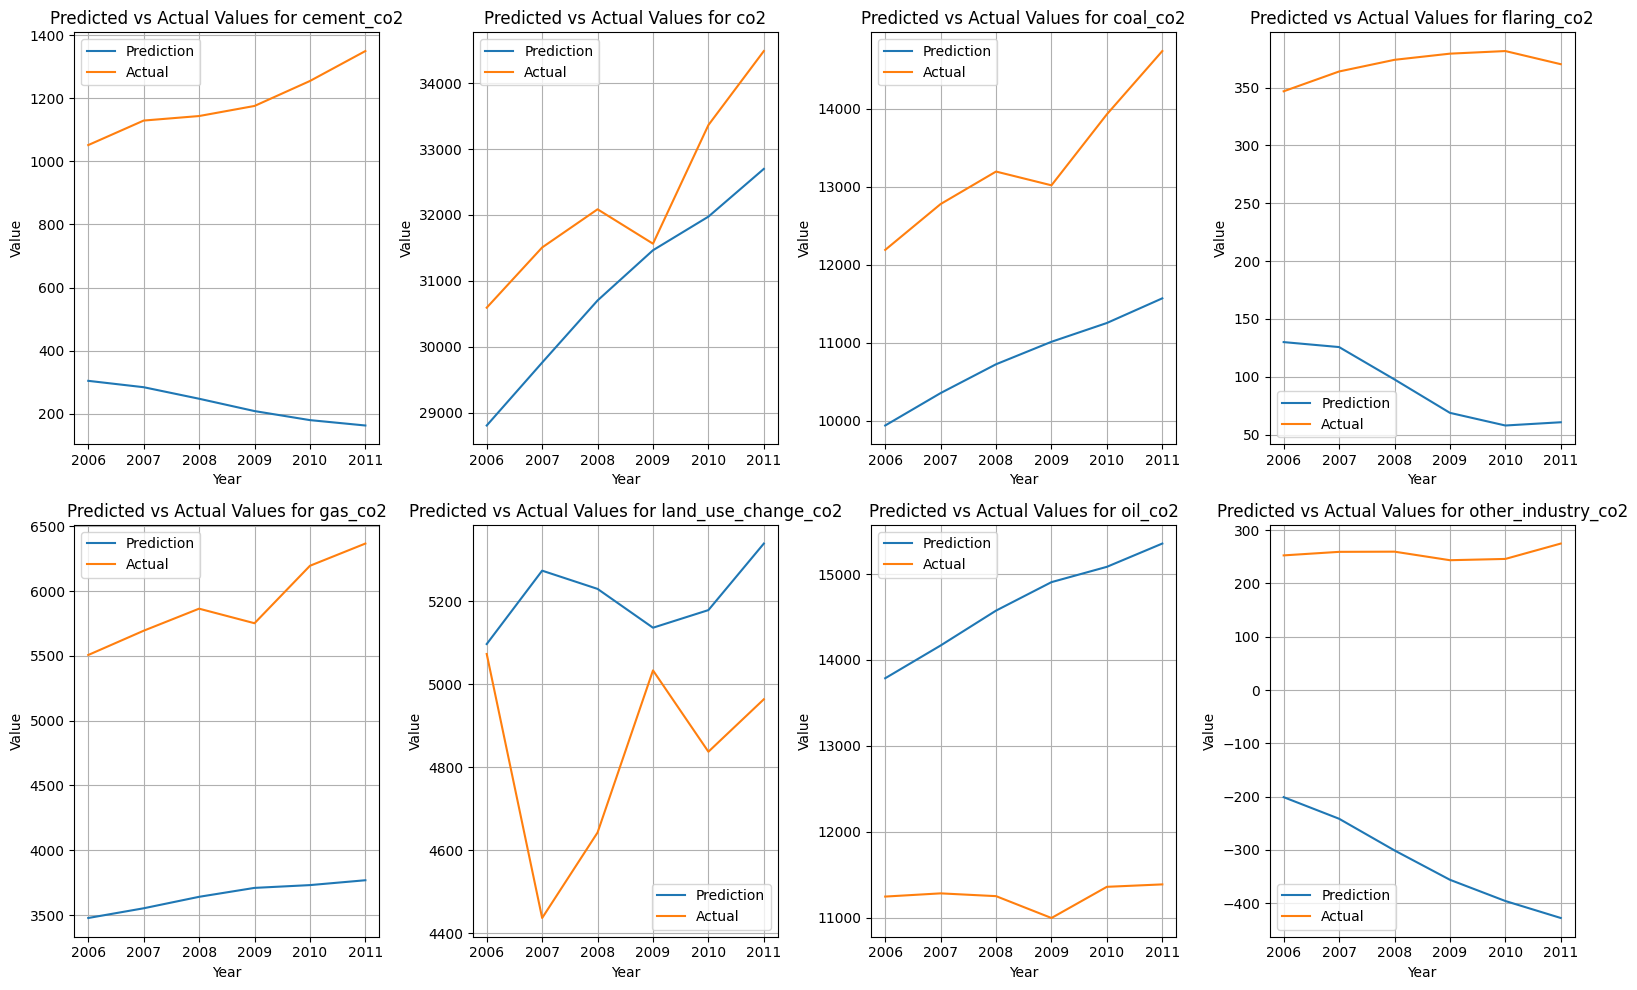

In [33]:
num_rows = 2
num_cols = 4

fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 10))

for idx, column in enumerate(feature_columns):
    result_df = results_of_features_df[idx]
    
    row = idx // num_cols
    col = idx % num_cols
    
    ax = axes[row, col]
    ax.plot(result_df.index, result_df['Prediction'], label='Prediction')
    ax.plot(result_df.index, result_df['Actual'], label='Actual')
    ax.set_xlabel('Year')
    ax.set_ylabel('Value')
    ax.set_title(f'Predicted vs Actual Values for {column}')
    ax.legend()
    ax.grid(True)


plt.tight_layout()
plt.show()

# Forecasting Validation on the val set

In [34]:
val_pred = saved_model.predict(x_val)

val_feature_columns = validate_set.columns

for col_idx, column_name in enumerate(val_feature_columns):
    feature_pred = val_pred[:, col_idx]
    feature_actual = y_val[:, col_idx]

    metrics_df = print_metrics(feature_pred, feature_actual, f'Feature {column_name}')

    print(metrics_df)
    print("-" * 40)

1/1 [==============================] - 0s 11ms/step
                        MAE     RMSE   MAPE       R2
Feature cement_co2  1475.92  1476.67  11.94 -10097.1
----------------------------------------
                MAE    RMSE  MAPE    R2
Feature co2  437.58  479.96  0.01 -1.26
----------------------------------------
                      MAE     RMSE  MAPE     R2
Feature coal_co2  1979.43  2003.65  0.16 -643.1
----------------------------------------
                        MAE    RMSE   MAPE     R2
Feature flaring_co2  394.33  394.97  23.88 -870.4
----------------------------------------
                     MAE     RMSE  MAPE       R2
Feature gas_co2  3442.96  3448.86  0.84 -3556.09
----------------------------------------
                                 MAE     RMSE  MAPE     R2
Feature land_use_change_co2  1263.86  1275.86  0.23 -53.59
----------------------------------------
                     MAE     RMSE  MAPE      R2
Feature oil_co2  5155.85  5195.04   0.3 -380.44
--------

In [35]:
results_of_features_val = []

for idx, column in enumerate(feature_columns):
    pred_val_for_feature = val_pred[:, idx]
    y_val_for_feature = y_val[:, idx]

    result_df_val = pd.DataFrame({'Prediction': pred_val_for_feature, 'Actual': y_val_for_feature})
    result_df_val.index = validate_set.index[-5:]

    results_of_features_val.append(result_df_val)

# combining the dataframes together for the validation set
combined_results_df_val = pd.concat(results_of_features_val, axis=1, keys=feature_columns)

print(combined_results_df_val)

      cement_co2                     co2                  coal_co2             \
      Prediction    Actual    Prediction      Actual    Prediction     Actual   
year                                                                            
2017  102.499062  1507.923  35950.257812  36096.7380  12744.668945  14506.974   
2018  118.216743  1569.218  36160.246094  36826.5080  12697.120117  14746.831   
2019  132.671555  1617.507  36434.664062  37082.5590  12659.816406  14725.978   
2020  146.645065  1637.537  36706.339844  37103.2055  12623.906250  14174.564   
2021  125.141182  1672.592  36793.468750  37123.8520  12511.291992  14979.598   

     flaring_co2               gas_co2           land_use_change_co2  \
      Prediction   Actual   Prediction    Actual          Prediction   
year                                                                   
2017   29.992018  391.992  4030.338867  7144.928         5712.590820   
2018   24.858120  412.116  4077.246094  7529.847         5586.5

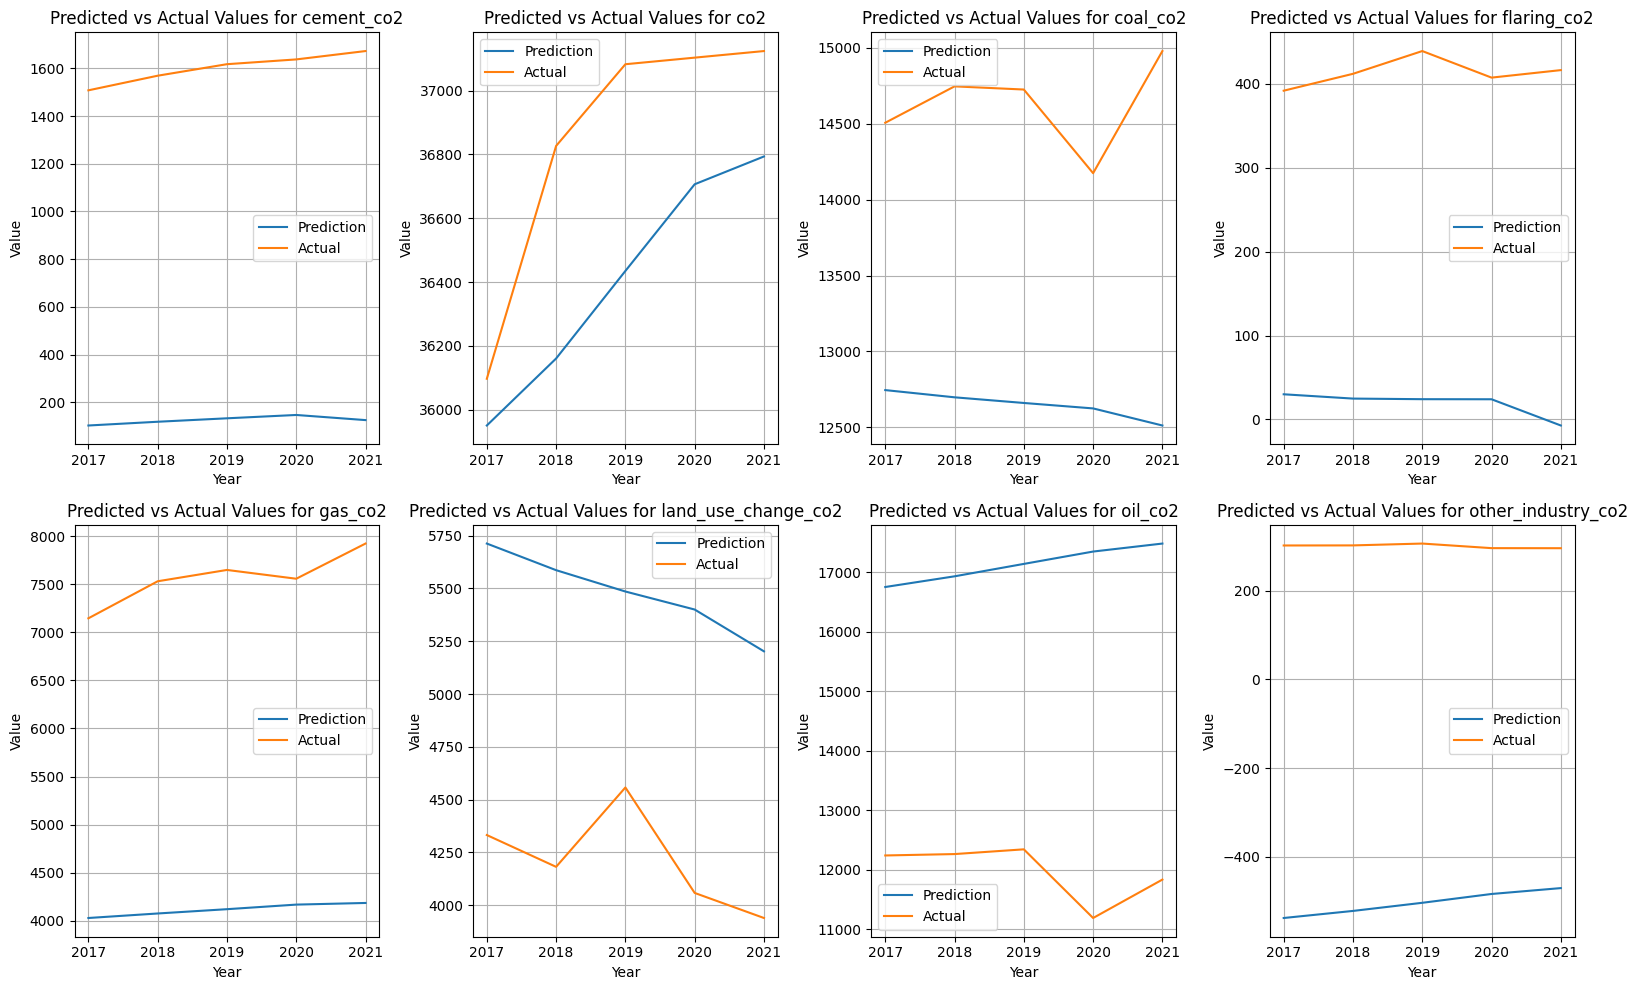

In [36]:
num_rows = 2
num_cols = 4

fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 10))

for idx, column in enumerate(feature_columns):
    result_df = results_of_features_val[idx]
    
    row = idx // num_cols
    col = idx % num_cols
    
    ax = axes[row, col]
    ax.plot(result_df.index, result_df['Prediction'], label='Prediction')
    ax.plot(result_df.index, result_df['Actual'], label='Actual')
    ax.set_xlabel('Year')
    ax.set_ylabel('Value')
    ax.set_title(f'Predicted vs Actual Values for {column}')
    ax.legend()
    ax.grid(True)


plt.tight_layout()
plt.show()

# Ensembling of the 2 Best Models 

In [37]:
model_a = load_model('Transformers_Best_Models_and_weights/Multivariate_best_model_weights_939.8892.hdf5')
model_b = load_model('Transformers_Best_Models_and_weights/Multivariate_best_model_weights_727.0049.hdf5')

In [38]:
pred_a = model_a.predict(x_test)
pred_b = model_b.predict(x_test)

1/1 [==============================] - 0s 227ms/step


In [39]:
val_pred_a = model_a.predict(x_val)
val_pred_b = model_b.predict(x_val)

1/1 [==============================] - 0s 13ms/step


In [40]:
weight_model_a = 0.4
weight_model_b = 0.6

In [41]:
ensemble_pred = (weight_model_a * pred_a) + (weight_model_b * pred_b)

ensemble_pred_val = ((weight_model_a * val_pred_a) + (weight_model_b * val_pred_b))

# Forecasting using the Ensembled Models

In [42]:
print_metrics(ensemble_pred, y_test, 'Transformer_Ensembled_Scores_TEST')

MAE     RMSE  MAPE      R2
Transformer_Ensembled_Scores_TEST  1320.79  1771.68   5.4 -207.06

In [43]:
print_metrics(ensemble_pred_val, y_val, 'Transformer_Ensembled_Scores_val')

MAE     RMSE  MAPE       R2
Transformer_Ensembled_Scores_val  1869.68  2391.48  2.47 -1815.55

In [44]:
pred_ensembled_flat = ensemble_pred.flatten()
y_test_flat = y_test.flatten()

# Create a DataFrame to compare predictions and actual values
ensembled_result_df = pd.DataFrame({'Prediction': pred_ensembled_flat, 'Actual': y_test_flat})

ensembled_result_df.index = test_set.index[-6:]

print("TEST Set:")
print("\n")
print(ensembled_result_df)

pred_ensembled_val_flat = ensemble_pred_val.flatten()
y_val_flat = y_val.flatten()

# Create a DataFrame to compare predictions and actual values
ensembled_result_val_df = pd.DataFrame({'Prediction': pred_ensembled_val_flat, 'Actual': y_val_flat})

ensembled_result_val_df.index = test_set.index[-5:]

print("\n")
print("VAL Set:")
print("\n")
print(ensembled_result_val_df)

ValueError: Length mismatch: Expected axis has 48 elements, new values have 6 elements

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(result_df.index, ensembled_result_df['Prediction'], label='Prediction')
plt.plot(result_df.index, ensembled_result_df['Actual'], label='Actual')
plt.xlabel('Year')
plt.ylabel('Value')
plt.title('Test Set: Predicted vs Actual Values')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(result_df_val.index, ensembled_result_val_df['Prediction'], label='Prediction')
plt.plot(result_df_val.index, ensembled_result_val_df['Actual'], label='Actual')
plt.xlabel('Year')
plt.ylabel('Value')
plt.title('Val set: Predicted vs Actual Values')
plt.legend()
plt.grid(True)
plt.show()